# Practical 2

**Group composition**: 
- Lucie-Marie BOSCHIAN CAMPANER &bull; [lucie-marie.boschiancampaner@ensiie.fr](mailto:lucie-marie.boschiancampaner@ensiie.fr)
- Khalil BATTIKH &bull; [khalil.battikh@ensiie.fr](mailto:khalil.battikh@ensiie.fr)
- Lucas RODRIGUEZ &bull; [lucas.rodriguez@ensiie.fr](mailto:lucas.rodriguez@ensiie.fr)

**Group ID**: 12

**Author**: *Lucas RODRIGUEZ*

## First steps

In [1069]:
# Importing the necessary libraries
import numpy as np
import pandas as pd
import missingno as msno
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import *
from keras_visualizer import visualizer
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import datetime
#from keras_tqdm import TQDMNotebookCallback
#from livelossplot import PlotLossesKeras
import tensorflow_addons as tfa
import time
import copy
# Silencing all warnings for a better UX
warnings.filterwarnings("ignore")

# Setting up a fixed random seed for experiment purposes
np.random.seed(1)

The chosen dataset is the following : **Air Quality**.

- Link of the dataset description: https://archive.ics.uci.edu/ml/datasets/Air+Quality
- Direct link to the dataset: https://archive.ics.uci.edu/ml/machine-learning-databases/00360/


**Selected strategy** : The given dataset offers a lot of features and observations. However, a lot of irregularities have been detected by us. We have to perform heavy transformations on the dataset using pre-processing operations.

To do so, we can first think about using Numpy, for matrix-based manipulations. However, we have decided to use Pandas to deal with tabular data more easily then convert the output version into a Numpy matrix as input for our NN model.

In [867]:
# Importing the given dataset
file_name = "data/AirQualityUCI.csv"
df = pd.read_csv(filepath_or_buffer=file_name,
                sep=";",
                #index_col="Date",
                na_values=np.nan,
                decimal=",") # Floating point separator for implicit casting

# Making a deep copy for safety reason
df_initial = df.copy(deep=True)

In [868]:
# Some informations about the different columns composing the csv file
df.info()

# General shape of the DataFrame
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB


(9471, 17)

In [869]:
# Statistical description of the final dataset
df.describe().transpose().round(3)

,count,mean,std,min,25%,50%,75%,max
CO(GT),9357.0,-34.208,77.657,-200.0,0.600,1.500,2.600,11.900
PT08.S1(CO),9357.0,1048.990,329.833,-200.0,921.000,1053.000,1221.000,2040.000
NMHC(GT),9357.0,-159.090,139.789,-200.0,-200.000,-200.000,-200.000,1189.000
C6H6(GT),9357.0,1.866,41.380,-200.0,4.000,7.900,13.600,63.700
PT08.S2(NMHC),9357.0,894.595,342.333,-200.0,711.000,895.000,1105.000,2214.000
NOx(GT),9357.0,168.617,257.434,-200.0,50.000,141.000,284.000,1479.000
PT08.S3(NOx),9357.0,794.990,321.994,-200.0,637.000,794.000,960.000,2683.000
NO2(GT),9357.0,58.149,126.940,-200.0,53.000,96.000,133.000,340.000
PT08.S4(NO2),9357.0,1391.480,467.210,-200.0,1185.000,1446.000,1662.000,2775.000
PT08.S5(O3),9357.0,975.072,456.938,-200.0,700.000,942.000,1255.000,2523.000


The dataset initially contains 9471 rows and 16 columns.

### Dataset description

The dataset contains 9358 instances of hourly averaged responses from an array of 5 metal oxide chemical sensors embedded in an Air Quality Chemical Multisensor Device. The device was located on the field in a significantly polluted area, at road level,within an Italian city. Data were recorded from March 2004 to February 2005 (one year)representing the longest freely available recordings of on field deployed air quality chemical sensor devices responses. Ground Truth hourly averaged concentrations for CO, Non Metanic Hydrocarbons, Benzene, Total Nitrogen Oxides (NOx) and Nitrogen Dioxide (NO2) and were provided by a co-located reference certified analyzer. Evidences of cross-sensitivities as well as both concept and sensor drifts are present as described in De Vito et al., Sens. And Act. B, Vol. 129,2,2008 (citation required) eventually affecting sensors concentration estimation capabilities. Missing values are tagged with -200 value. 


---

0. Date (format: DD/MM/YYYY)
1. Time (format: HH.MM.SS)
2. True hourly averaged concentration CO in $\text{mg}/\text{m}^3$ (reference analyzer) 
3. PT08.S1 (tin oxide) hourly averaged sensor response (nominally CO targeted) 
4. True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) 
5. True hourly averaged Benzene concentration in microg/m^3 (reference analyzer) 
6. PT08.S2 (titania) hourly averaged sensor response (nominally NMHC targeted) 
7. True hourly averaged NOx concentration in ppb (reference analyzer) 
8. PT08.S3 (tungsten oxide) hourly averaged sensor response (nominally NOx targeted) 
9. True hourly averaged NO2 concentration in microg/m^3 (reference analyzer) 
10. PT08.S4 (tungsten oxide) hourly averaged sensor response (nominally NO2 targeted) 
11. PT08.S5 (indium oxide) hourly averaged sensor response (nominally O3 targeted) 
12. Temperature (in °C)
13. Relative Humidity (%) 
14. AH: Absolute Humidity


---

Add the choice of target/features


### Dataset references & License



Saverio De Vito (saverio.devito@enea.it), ENEA - National Agency for New Technologies, Energy and Sustainable Economic Development

In [870]:
# A quick overview of the dataset structure
df.head(10)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN
5,10/03/2004,23.00.00,1.2,1197.0,38.0,4.7,750.0,89.0,1337.0,96.0,1393.0,949.0,11.2,59.2,0.7848,NaN,NaN
6,11/03/2004,00.00.00,1.2,1185.0,31.0,3.6,690.0,62.0,1462.0,77.0,1333.0,733.0,11.3,56.8,0.7603,NaN,NaN
7,11/03/2004,01.00.00,1.0,1136.0,31.0,3.3,672.0,62.0,1453.0,76.0,1333.0,730.0,10.7,60.0,0.7702,NaN,NaN
8,11/03/2004,02.00.00,0.9,1094.0,24.0,2.3,609.0,45.0,1579.0,60.0,1276.0,620.0,10.7,59.7,0.7648,NaN,NaN
9,11/03/2004,03.00.00,0.6,1010.0,19.0,1.7,561.0,-200.0,1705.0,-200.0,1235.0,501.0,10.3,60.2,0.7517,NaN,NaN


## Data pre-processing & Data-cleaning

### Drop duplicates

We can handle duplicate rows by using the following instruction


In [871]:
df.drop_duplicates(inplace=True) # we keep the "keep" argument to its default value : "first"
df.shape

(9358, 17)

We have successfully eliminated $9471 - 9347 = \fbox{124}$ rows (especially, most of them were rows filled of NaN values (see next section). 

**Remark** : Most of them have been removed thanks to the `drop_duplicate` operation. However, we still have a remaining row at the end. We remove it.

In [872]:
df.dropna(how="all", inplace=True)
df.shape

(9357, 17)

In [873]:
# We first determine for each column, the number of different values in this column by using the following Pandas method
df.nunique()

Date              391
Time               24
CO(GT)             97
PT08.S1(CO)      1042
NMHC(GT)          430
C6H6(GT)          408
PT08.S2(NMHC)    1246
NOx(GT)           926
PT08.S3(NOx)     1222
NO2(GT)           284
PT08.S4(NO2)     1604
PT08.S5(O3)      1744
T                 437
RH                754
AH               6684
Unnamed: 15         0
Unnamed: 16         0
dtype: int64

### Drop useless columns

We can easily see, thanks to the previous cell, that the last two columns are completely empty

$\Longrightarrow$ We immediately remove them.

In [874]:
try: # try-except block in order to catch the thrown exception in case of re-execution 
    df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)
    df.shape
except KeyError:
    print("Columns already removed.")
df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,04/04/2005,10.00.00,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
9353,04/04/2005,11.00.00,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
9354,04/04/2005,12.00.00,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406
9355,04/04/2005,13.00.00,2.1,1003.0,-200.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139


### Customizing the inner structure of the dataset

We observe that `Date` and `Time` are `object`-typed. Since we want to perform a regression model on our data, we want to explain the target variable with the widest subset of possible features.



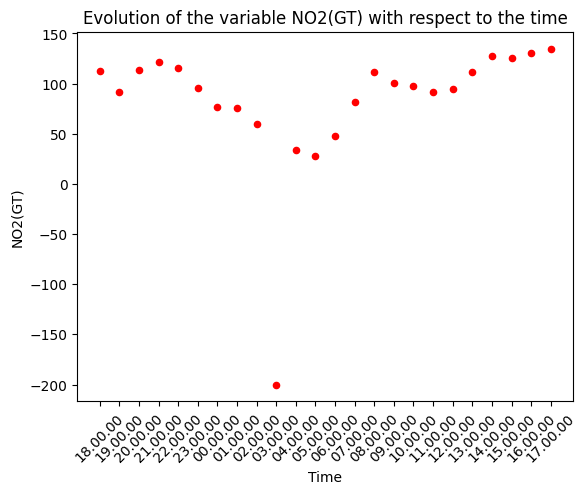

In [876]:
_ = df[0:24].plot.scatter("Time", "NO2(GT)", 
                      rot=45, 
                      color="red"
                     )
_ = plt.title("Evolution of the variable NO2(GT) with respect to the time")

We can see that, on the scale of only one day, the evolution of concentration of some substances is clearly highlighted here.

We have:
- `Date`: DD/MM/YYYY
- `Time`: HH.MM.SS (but the frequency of observation is an hourly-basis.



We also observe that the date range goes from 10/03/2004 to 03/04/2005; we can remove the year detail and only encode the month as follows:
- March 2004 $\longrightarrow 0$
- April 2004 $\longrightarrow 1$ 
- ...

As shown in the below figures, we see that there is no clear reason in keeping the days into the dataset; we remove them.

<img src="img/cal1.png" width=600>

<img src="img/cal2.png" width=600>


In fact, there is no need to keep the days because of the combination of the record id (represented by the index of the row) and the hours.


To conclude, we have decided to keep the months (as an encoded field) and the hours (the minutes and seconds dedicated fields are empty because of the hourly refresh time frequency.

In [877]:
# Creating the month column
get_month = lambda x:x.split("/")[1][1] if x.split("/")[1][0] == '0' else x.split("/")[1]
df["Month"] = df["Date"].apply(get_month)
df["Month"] = pd.to_numeric(df["Month"])

In [878]:
# Creating the hour column
get_hour = lambda x:x.split(".")[0][0] if x.split(".")[0][0] == '0' else x.split(".")[0]
df["Hour"] = df["Time"].apply(get_hour)
df["Hour"] = pd.to_numeric(df["Hour"])

In [879]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Month          9357 non-null   int64  
 16  Hour           9357 non-null   int64  
dtypes: float64(13), int64(2), object(2)
memory usage: 1.

In [880]:
# Dropping the column Date and Time
try: # try-except block in order to catch the thrown exception in case of re-execution 
    df.drop(['Date', 'Time'], axis=1, inplace=True)
    df.shape
except KeyError:
    print("Columns already removed.")
df

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Month,Hour
0,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,3,18
1,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,3,19
2,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,3,20
3,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,3,21
4,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,3,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.0,-200.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,4,10
9353,2.4,1163.0,-200.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,4,11
9354,2.4,1142.0,-200.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,4,12
9355,2.1,1003.0,-200.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,4,13


### Thresholding the values ($-200 = \text{NaN}$)

We have remarked the following highlight from the dataset webpage:
> Missing values are tagged with -200 value. 

We have to replace all values under $-200$ by a NaN item; we will then deal with them in the next section:

In [881]:
columns_float = ['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH']
df[df[columns_float] <= -200] = np.nan

### Handling missing values (NaN)

In order to train and validate our model, we cannot tolerate the presence of NaN values within the input dataset; we have to remove all of them.

To have a graphical confirmation, we can produce the two bar plots below showing the "distribution" of the missing values among our dataset.

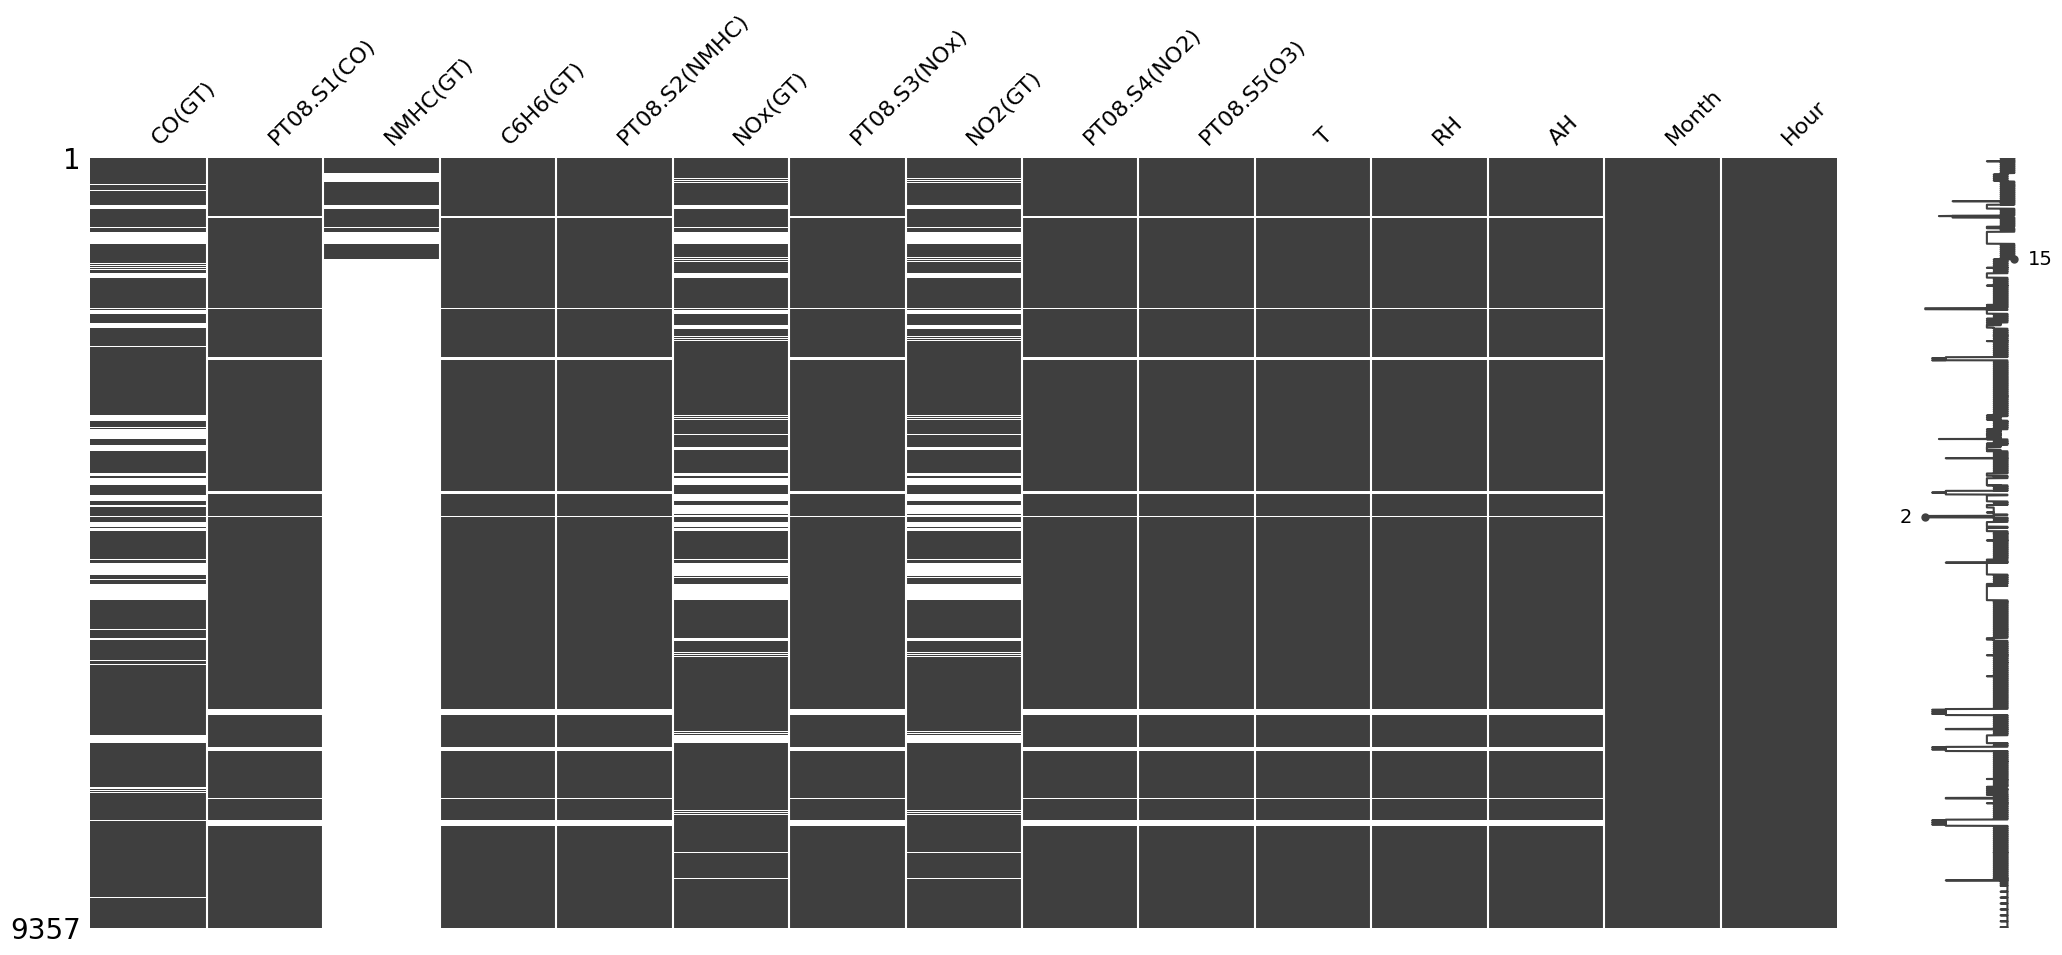

In [882]:
_ = msno.matrix(df)

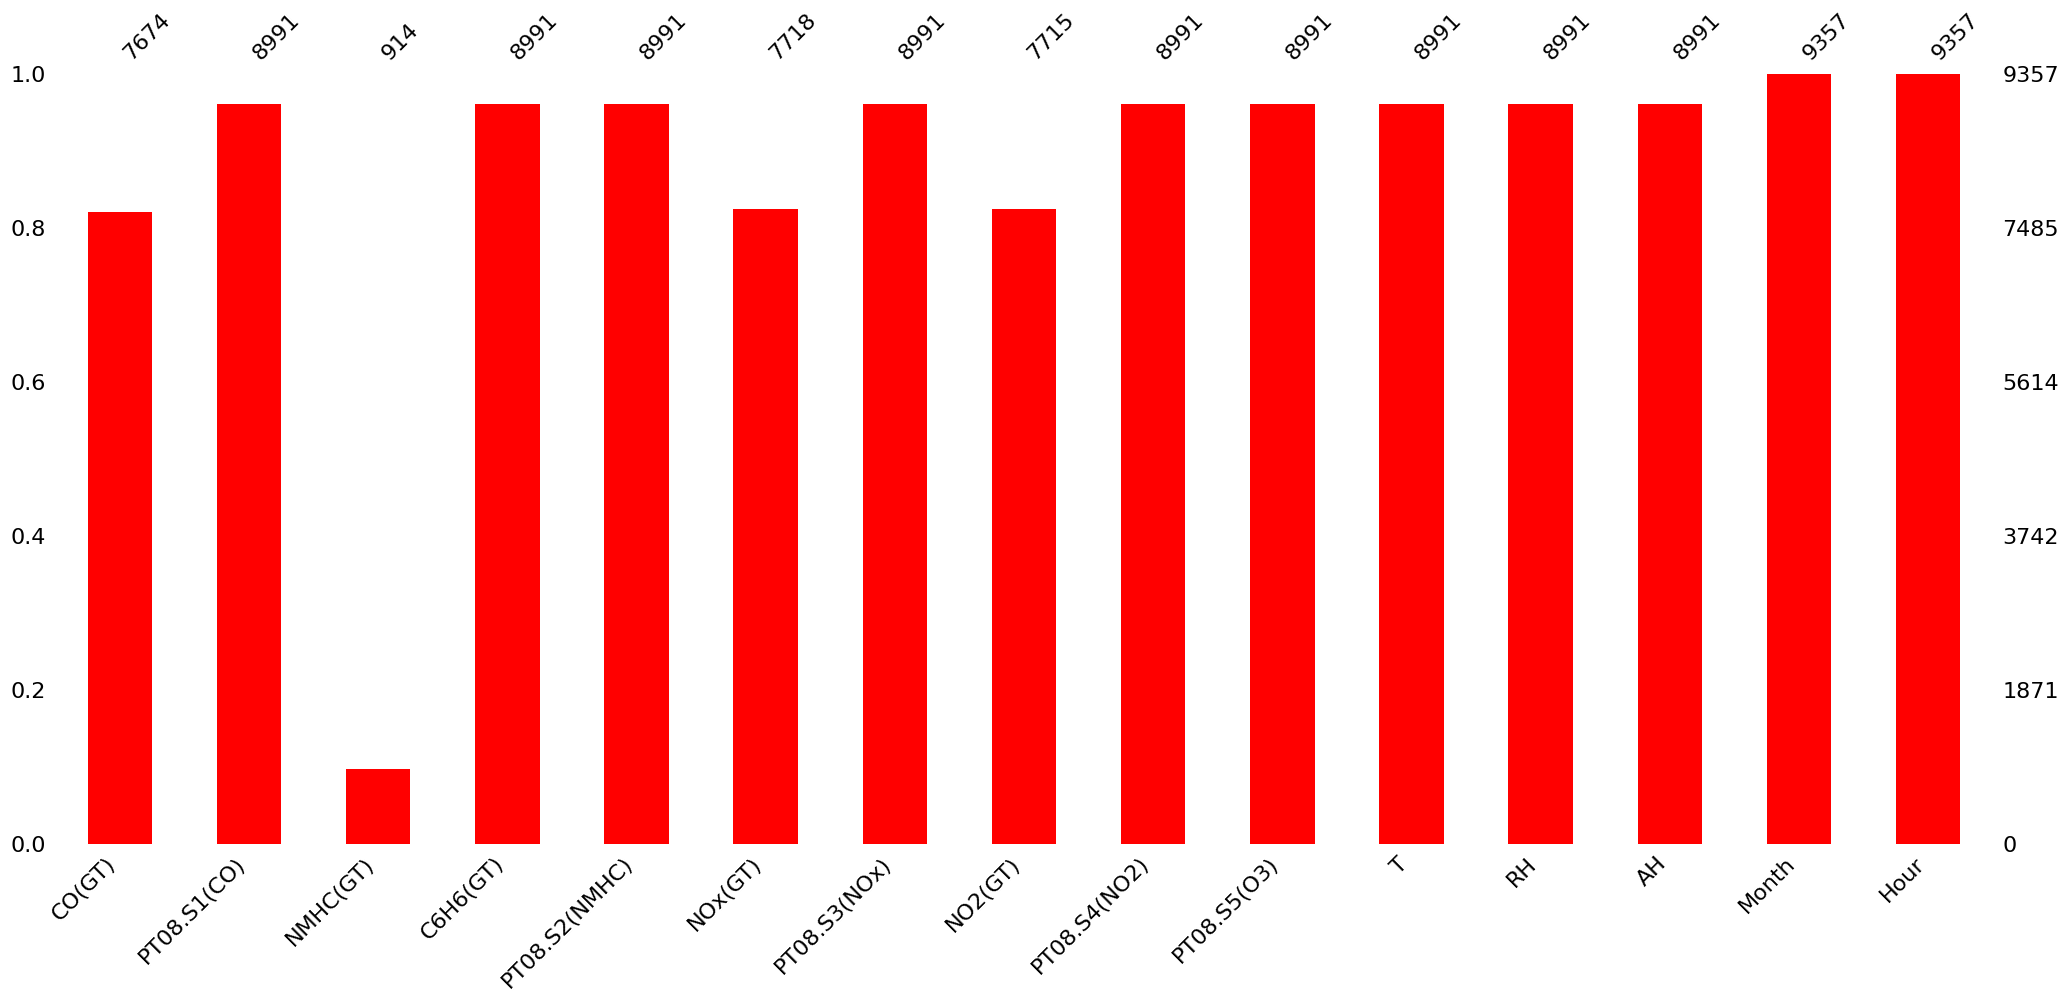

In [883]:
_ = msno.bar(df, color="red")

The feature : **`NMHC(GT)`** has a high proportion of NaN elements 

$\Longrightarrow$ This column cannot provide meaningful conclusion on the selected target.

$\Longrightarrow$ We decide to remove the column **`NMHC(GT)`**.

In [885]:
# Dropping the column NMHC(GT)
try: # try-except block in order to catch the thrown exception in case of re-execution 
    df.drop(['NMHC(GT)'], axis=1, inplace=True)
    df.shape
except KeyError:
    print("Column already removed.")
df

Column already removed.


,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Month,Hour
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,3,18
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,3,19
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,3,20
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,3,21
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,3,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,4,10
9353,2.4,1163.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,4,11
9354,2.4,1142.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,4,12
9355,2.1,1003.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,4,13


The other columns have a proportion of non-NaN greater than $80 \ \%$, which contains most of the information of the corresponding feature; we can replace these NaN values by a significant statistical indicator such as : median or mean value.

$\Longrightarrow$ We choose the **average** value here.

In [886]:
# Removing the NMHC(GT) column
try:
    columns_float.remove('NMHC(GT)')
except ValueError:
    pass
columns_float
for c in columns_float:
    df[c].fillna(df[c].mean(), inplace=True) # or .median()

In [887]:
# Computing the percentage of remaining missing values
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing

CO(GT)           0.0
PT08.S1(CO)      0.0
C6H6(GT)         0.0
PT08.S2(NMHC)    0.0
NOx(GT)          0.0
PT08.S3(NOx)     0.0
NO2(GT)          0.0
PT08.S4(NO2)     0.0
PT08.S5(O3)      0.0
T                0.0
RH               0.0
AH               0.0
Month            0.0
Hour             0.0
dtype: float64

We're good to go !

In [888]:
df.head(10)

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Month,Hour
0,2.6,1360.0,11.9,1046.0,166.000000,1056.0,113.000000,1692.0,1268.0,13.6,48.9,0.7578,3,18
1,2.0,1292.0,9.4,955.0,103.000000,1174.0,92.000000,1559.0,972.0,13.3,47.7,0.7255,3,19
2,2.2,1402.0,9.0,939.0,131.000000,1140.0,114.000000,1555.0,1074.0,11.9,54.0,0.7502,3,20
3,2.2,1376.0,9.2,948.0,172.000000,1092.0,122.000000,1584.0,1203.0,11.0,60.0,0.7867,3,21
4,1.6,1272.0,6.5,836.0,131.000000,1205.0,116.000000,1490.0,1110.0,11.2,59.6,0.7888,3,22
5,1.2,1197.0,4.7,750.0,89.000000,1337.0,96.000000,1393.0,949.0,11.2,59.2,0.7848,3,23
6,1.2,1185.0,3.6,690.0,62.000000,1462.0,77.000000,1333.0,733.0,11.3,56.8,0.7603,3,0
7,1.0,1136.0,3.3,672.0,62.000000,1453.0,76.000000,1333.0,730.0,10.7,60.0,0.7702,3,0
8,0.9,1094.0,2.3,609.0,45.000000,1579.0,60.000000,1276.0,620.0,10.7,59.7,0.7648,3,0
9,0.6,1010.0,1.7,561.0,246.896735,1705.0,113.091251,1235.0,501.0,10.3,60.2,0.7517,3,0


In [889]:
# Saving the pre-processed dataset on disk
df.to_csv(path_or_buf="data/processed_dataset.csv",
         sep=";",
         header=True)

### $X$/$Y$ dataset split

We now have to split the main dataset into $X$ and $Y$ dataframes.

As a reminder:
- $X$ represents the features matrix
- $Y$ represents the target variable (as a vector or Pandas Series to be more precise)

In [890]:
# Splitting the dataset
X = df.copy() # X as a deep copy for security reason
Y = X.pop("T")

In [891]:
# Features
X.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),RH,AH,Month,Hour
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,48.9,0.7578,3,18
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,47.7,0.7255,3,19
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,54.0,0.7502,3,20
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,60.0,0.7867,3,21
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,59.6,0.7888,3,22


In [892]:
# Target
Y.head()

0    13.6
1    13.3
2    11.9
3    11.0
4    11.2
Name: T, dtype: float64

### Handling outliers

<p style="color:red"> 
    <b>WARNING</b>: This step has to be performed <b>RIGHT AFTER</b> the train/test/validation split <b>AND ONLY</b> on the train set.
</p>

In order to check the presence of outliers within our dataset, we analyze the box-plot of each column.

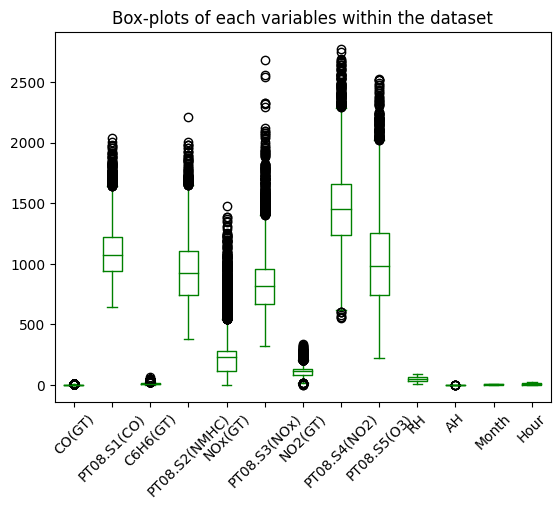

In [893]:
X.plot(kind="box",
       title="Box-plots of each variables within the dataset",
       color="green", xlabel=None)
_ = plt.xticks(rotation=45)

We can observe a lot of outliers, in particular for `PT08.S1(CO)`, `NOx(GT)`, and `PT08.S3(NOx)`and `PT08.S4(NO2)`.

At first sight, we wanted to perform some data pre-processing on the outliers. Our first track was to implement the **Winsorize method** which rescales the observations and tries to replace the outliers by "normal values".

However, since we don't want to facilitate **over-fitting** potential behaviors and as we also want to introduce noise in the coming steps within the feedforwarding step, we do not pursue on this track.

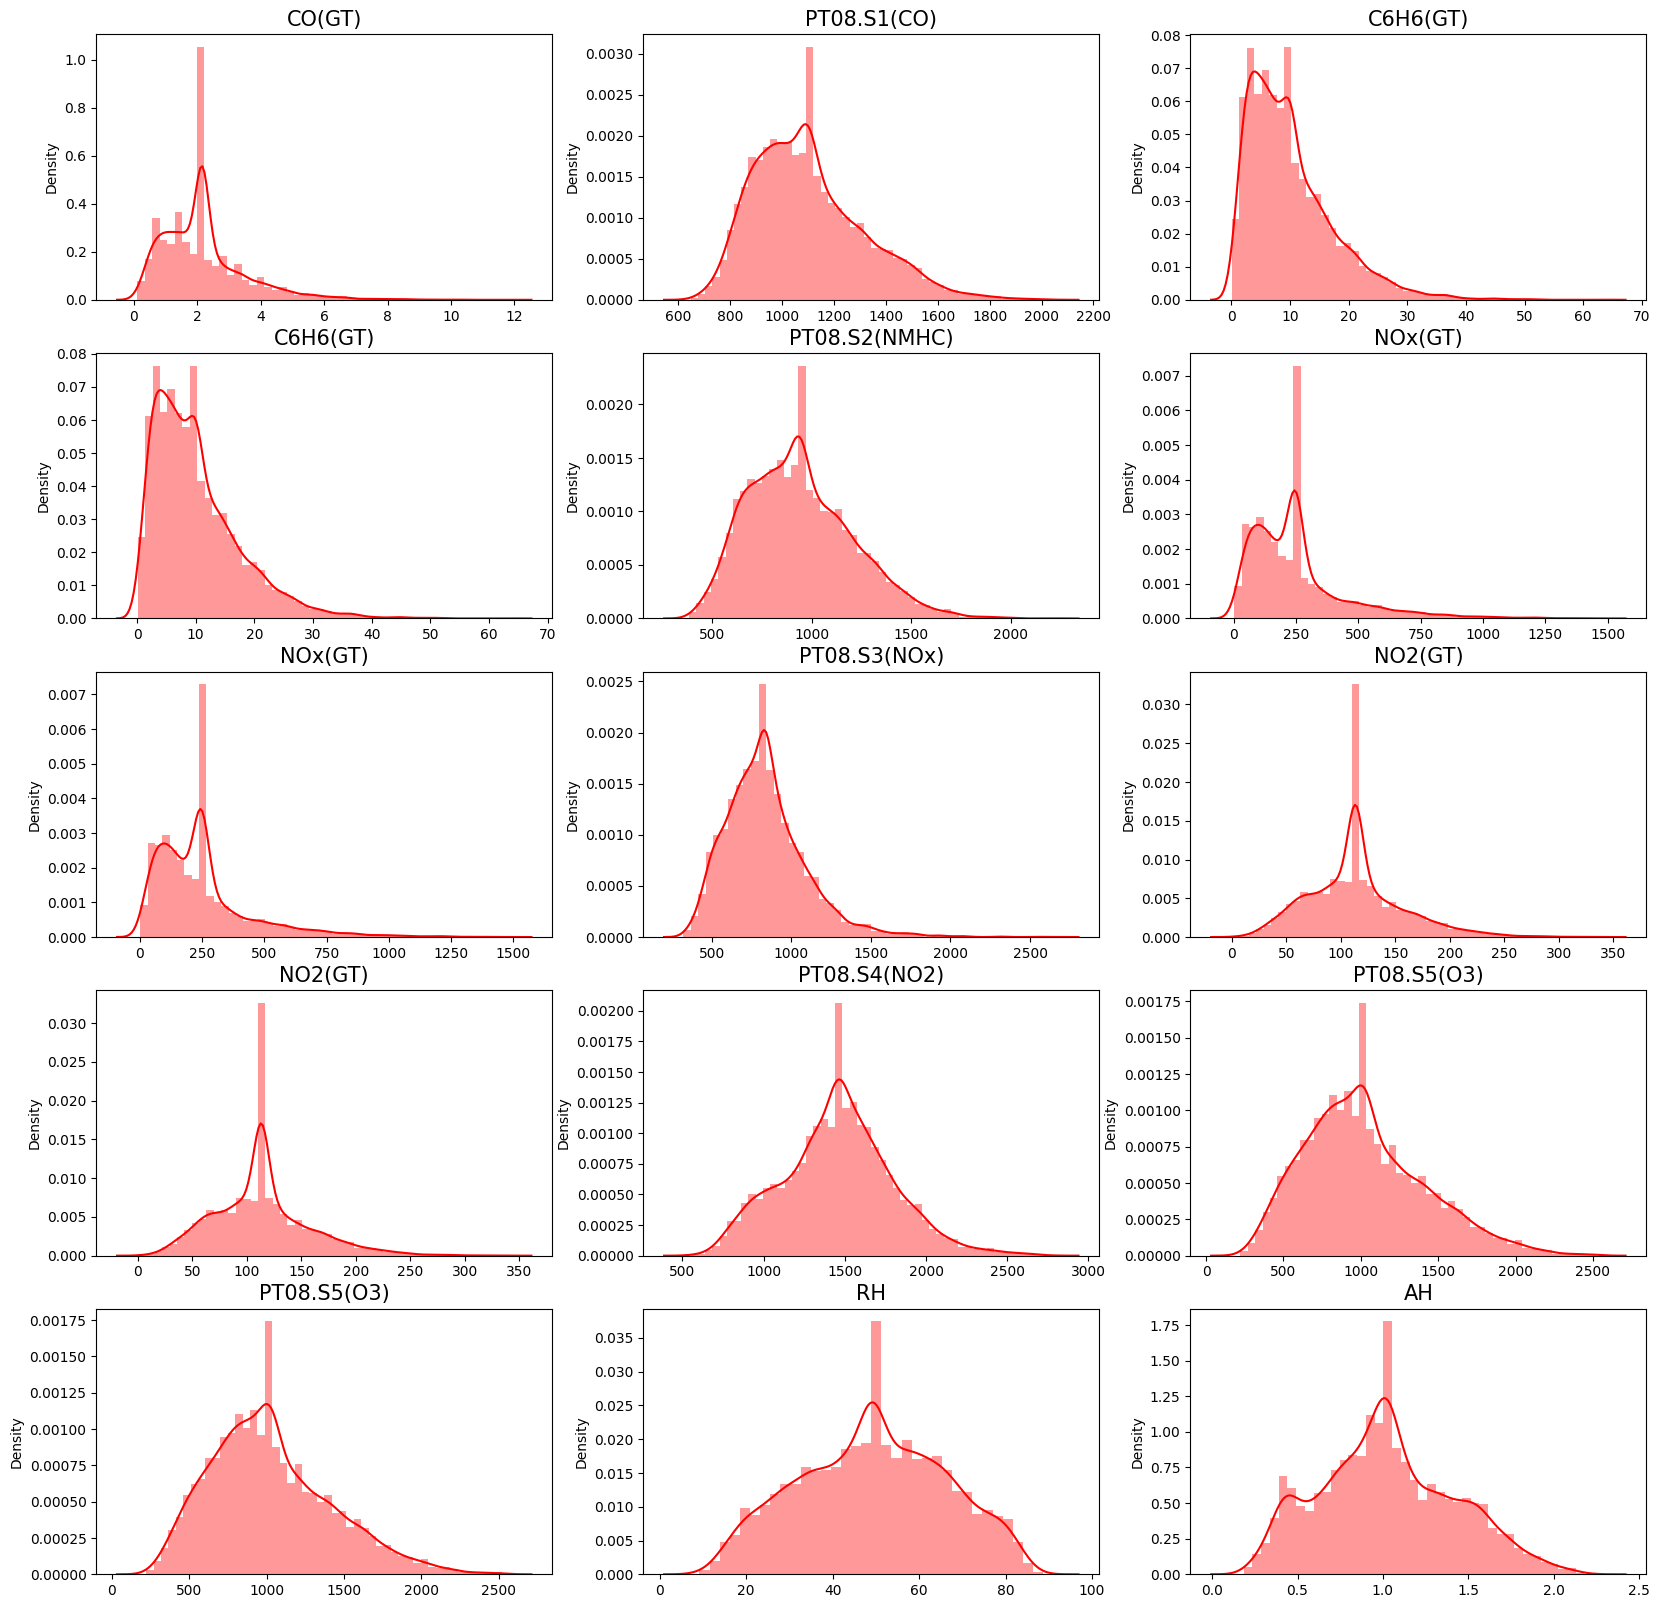

In [894]:
# Plotting distribution plots for each column
fig, ax = plt.subplots(5, 3, figsize=(20, 20))
for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        g = sns.distplot(X[X.columns[i*2+j]], ax=ax[i][j], color="red")
        g.set(xlabel=None)
        g.set_title(X[X.columns[i*2+j]].name, fontsize = 15)

### Handling high-correlated data

Linear regression cannot perform a good fitting process with highly-correlated features.
Given a specific threshold, we will remove the most correlated variables in order to obtain consistent results.

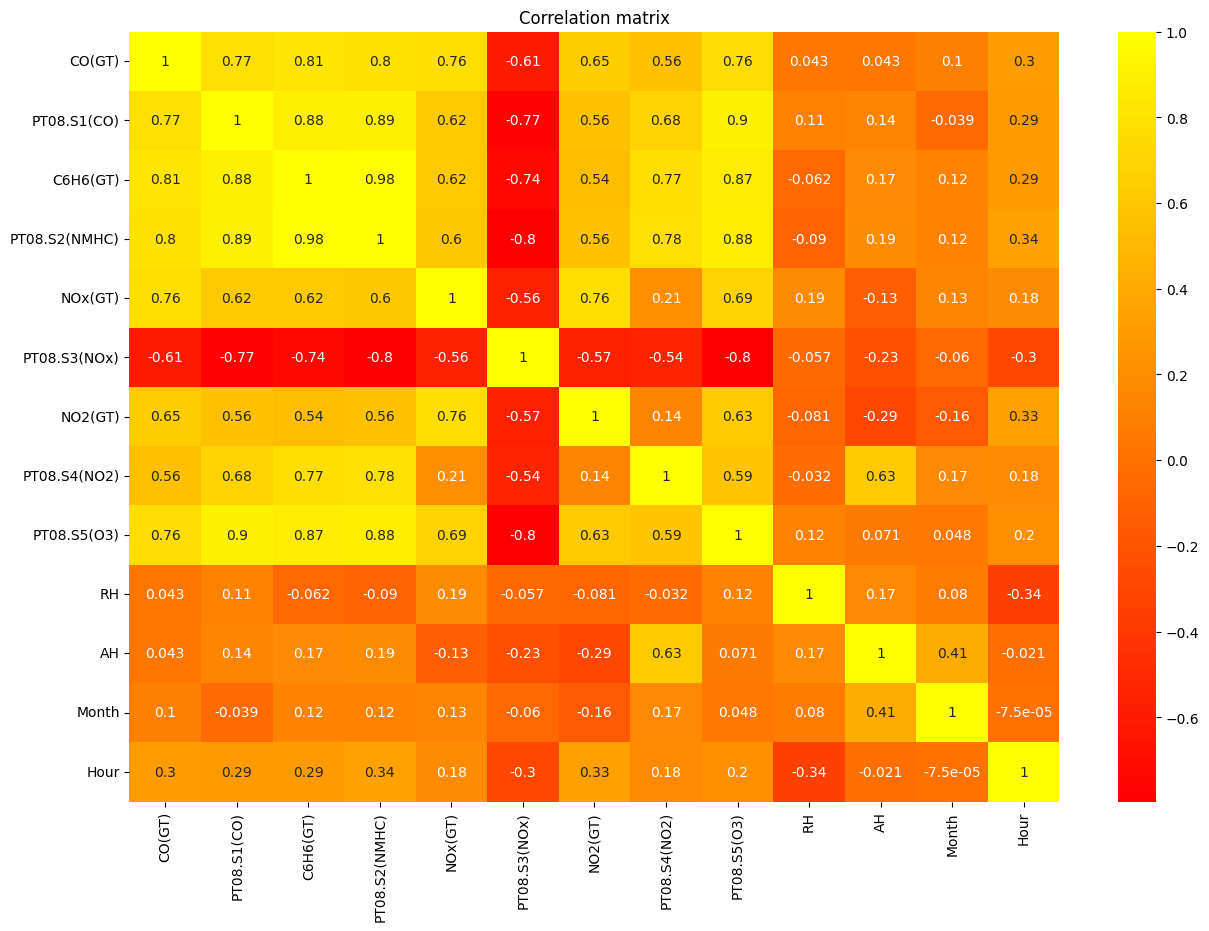

In [895]:
# Computing and plotting the correlation matrix of the final dataset
plt.figure(figsize=(15, 10))
correlation_matrix = X.corr() #.abs()
sns.heatmap(correlation_matrix, annot=True, cmap="autumn")
plt.title("Correlation matrix")
plt.show()

We remark that the upper left-hand corner contains highly-correlated variables.

In [896]:
# Select upper triangle of correlation matrix (because it's a symmetric matrix)
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
#print(upper)

# Find features with correlation greater than a fixed threshold
HIGH_CORRELATION_THRESHOLD = 0.88
to_drop = [column for column in upper.columns if any(upper[column] > HIGH_CORRELATION_THRESHOLD)]
print(f"We drop the following variables: {to_drop}")

We drop the following variables: ['C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S5(O3)']


With a threshold of $0.88$, we have to remove the most high-correlated variables which are : `C6H6(GT)`, `PT08.S2(NMHC)` and `PT08.S5(O3)`.

In [899]:
# Drop selected features
try:
    if len(to_drop) != 0:
        print(f"We drop the following variables: {to_drop}")
        X.drop(to_drop, axis=1, inplace=True)
        print("Removing high-correlated columns")
    else:
        print("High-correlated features have already been removed by the user.")
except:
    print("High-correlated features have already been removed by the user.")

We drop the following variables: ['C6H6(GT)', 'PT08.S2(NMHC)', 'PT08.S5(O3)']
High-correlated features have already been removed by the user.


In [834]:
# (Obsolete) Alternative method to find pairs of heavy-correlated variables
#c = df.corr().abs()
#s = c.unstack()
#so = s.sort_values(kind="quicksort")
#so.drop(so)
#HIGH_CORRELATION_THRESHOLD = 0.85
#so[(so != 1.0) & (so > HIGH_CORRELATION_THRESHOLD)].drop_duplicates().keys()

### Train/test dataset split

In [900]:
# Size setting
SIZE_SAMPLE_TEST = 0.3
SIZE_SAMPLE_VALIDATION = 0.3

# Creation of training and testing dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size = SIZE_SAMPLE_TEST)
# Shuffling
#X_train.sample(frac=1)
#X_test.sample(frac=1)

In [901]:
#X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=SIZE_SAMPLE_VALIDATION)

# Shuffling
#X_train.sample(frac=1)
#X_val.sample(frac=1)

#### Outliers detection & correction

In [902]:
def apply_outliers_detect_col(col):
    """
    Function returning an outliers-corrected column from the initial column : col
    :param col: Initial column
    """
    return winsorize(col, limits=[0.05, 0.05])

def apply_outliers_detect(df):
    """
    Function returnin an outliers-corrected dataframe from the initial dataframe : df
    :param df: Initial dataframe
    """
    return df.apply(apply_outliers_detect_col, axis = 0)

# Applying the filtering of outliers on the train dataset ONLY
#X_train = apply_outliers_detect(X_train)
#X_train

### Features normalization

We can use one of the several scalers available in *scikit-learn*:

- `MinMaxScaler`: subtracts the min value in the feature and dividing by the range of the feature. The MinMaxScaler does not change the shape of the distribution but shrinks the frequency distribution between 0 to 1.  
- `StandardScaler`: rescales the data by subtracting all the entries from the mean value and dividing it by the standard deviation. After a StandardScaler step has been carried out, the mean of the distribution is equal to zero while 67.7% of the distribution falls between -1 and 1
- `RobustScaler` : subtracts the median value from each entry and divides by the interquartile range (IQR) of the feature. Since RobustScaler divides by the interquartile range, the returned frequency distribution penalizes outliers. This makes RobustScaler robust for data with outliers. 


$\Longrightarrow$ Since we have a lot of outliers on many features (see previous sections), we are encouraged to use the `RobustScaler` transform.

In [903]:
# Normalization process using the RobustScaler processor
scaler = MinMaxScaler() # RobustScaler()
#scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [904]:
# New results scaled and centered
X_train

array([[0.22033898, 0.45722502, 0.27253064, ..., 0.38159546, 0.18181818,
        0.        ],
       [0.71186441, 0.70524802, 0.78370584, ..., 0.15507807, 1.        ,
        0.7826087 ],
       [0.29661017, 0.43781452, 0.29704398, ..., 0.20829359, 0.18181818,
        0.82608696],
       ...,
       [0.17396183, 0.27606039, 0.17656578, ..., 0.48958281, 0.27272727,
        0.47826087],
       [0.17396183, 0.05319914, 0.17656578, ..., 0.3805914 , 0.81818182,
        0.        ],
       [0.21186441, 0.60819554, 0.11968277, ..., 0.37321151, 0.18181818,
        0.56521739]])

In [905]:
X_test

array([[0.08474576, 0.28612509, 0.04470079, ..., 0.32411266, 0.27272727,
        0.        ],
       [0.02542373, 0.14306254, 0.05263158, ..., 0.21220945, 0.27272727,
        0.        ],
       [0.17396183, 0.34579439, 0.04902668, ..., 0.33917365, 0.18181818,
        0.        ],
       ...,
       [0.29661017, 0.47663551, 0.31506849, ..., 0.46332647, 0.90909091,
        0.43478261],
       [0.17396183, 0.43134436, 0.17656578, ..., 0.68658065, 0.72727273,
        0.        ],
       [0.15254237, 0.32422717, 0.07858688, ..., 0.63843566, 0.45454545,
        0.82608696]])

## NN model design

We want to study the effect of the following hyper-parameters:
- $\#$ of layers
- $\#$ of neurons
- learning rate
- regularization
- activation functions
- impact of normalizing your dataset
- impact of noising your dataset (after normalization)

### Preliminary steps

In [906]:
"""
Available callbacks:
- tfa.callbacks.TQDMProgressBar()
- livelossplot.PlotLossesKeras()
- keras_tqdm() <-- to be avoided
"""

# Initialize tqdm callback with default parameters
tqdm_callback = tfa.callbacks.TQDMProgressBar()

# Simple assertion for technical reason
tf.keras.models.Sequential == tf.keras.Sequential

True

### Model's creation and parametrization

In [907]:
# Creation of the neural network
model = Sequential()

# Input layer
model.add(Dense(units=12, input_dim=X.shape[1], activation="relu"))
# WARNING: the parameter input_dim has to be exactly equal to the number of column of X_train

# Hidden layers
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))

# Output layer
model.add(Dense(1, activation='linear'))

#### Model's architecture graphical representation

We can visualize the model graphically as shown below:

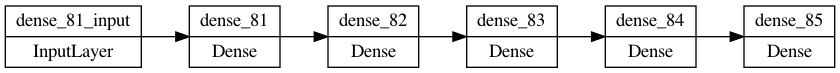

In [908]:
plot_model(model,
           to_file="img/graph_nn_1_alt.png",
           rankdir="LR")

A better graphical approach is:

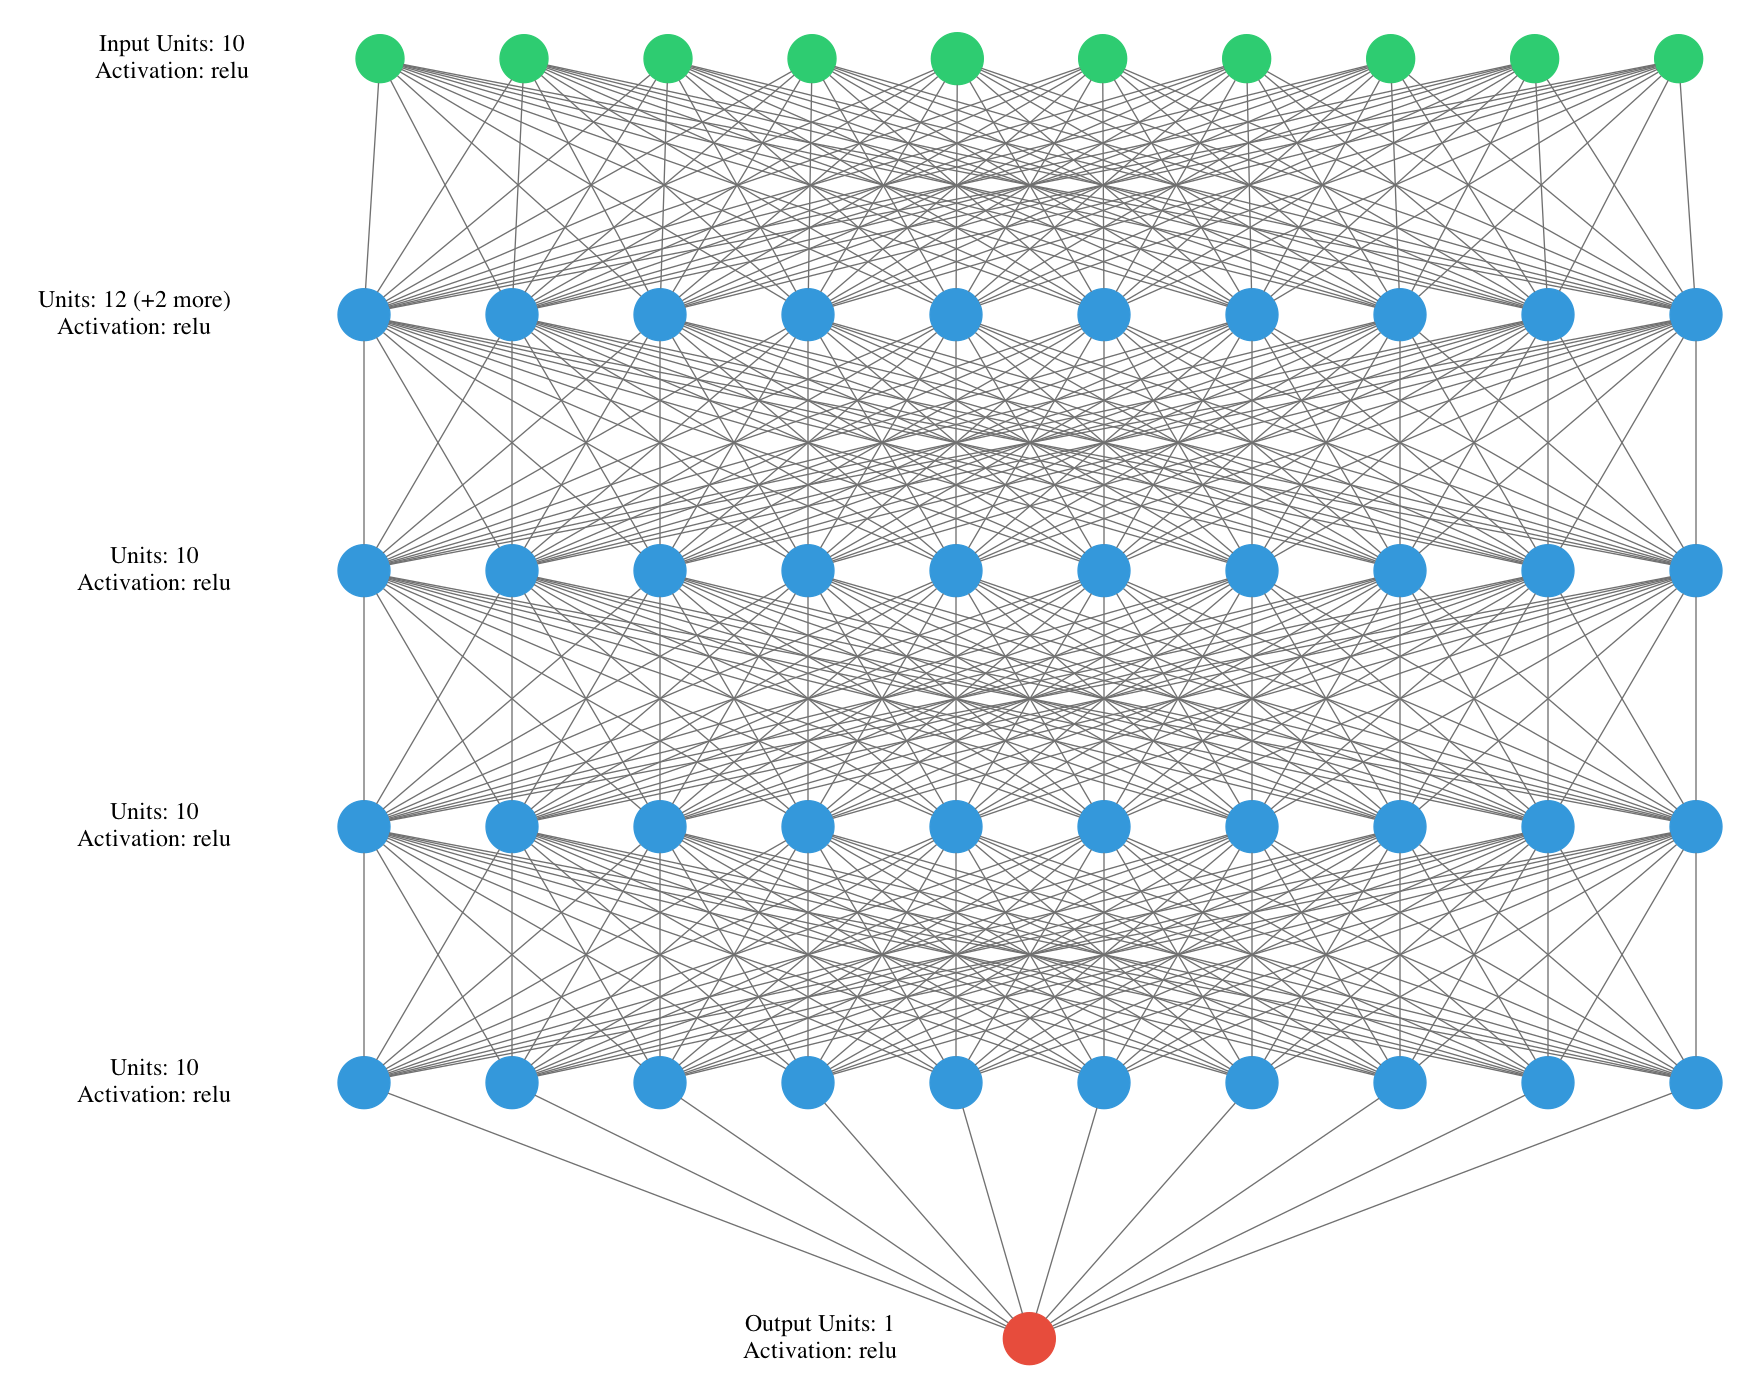

In [909]:
visualizer(model, 
           filename="img/graph_nn_1", 
           format='png', 
           view=False
          )
Image("img/graph_nn_1.png")

#### Optimizer's choice


In our neural network (NN), the optimizer 




#### Model's parameters


**References**:

- https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10

We now have to compile and fit the model with the training dataset:

In [932]:
# Definition of the different arguments
eta = 2e-3 # generally between 1e-2 and 1e-4
NB_EPOCHS = 30 #150

# Setting up the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=eta)

# Early Stopping
#es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="max")

# Compiling the model
model.compile(loss='mae', 
              optimizer=optimizer, 
              metrics=["mse", "mae"]
             )
type(model)
# The metric called `accuracy` is meaningless in our case because of the linear regression situation. 
# In fact, the accuracy is only meaningful in classification problems).

keras.engine.sequential.Sequential

In [911]:
# Fit step of the model
fit_start = time.time()
history = model.fit(x=X_train, y=Y_train, 
                    epochs=NB_EPOCHS,
                    validation_data=(X_test, Y_test),
                    #validation_split=0.3, # mettre validation_data avec X_test, Y_test
                    verbose=0,
                    callbacks=[tqdm_callback], # [es, tqdm_callback],
                    batch_size=10,
                    #workers=8,
                    #use_multiprocessing=True
                   )
fit_end = time.time()
fit_dur = np.abs(fit_end - fit_start)

Training:   0%|     0/30 ETA: ?s,  ?epochs/s

Epoch 1/30


0/655                             ETA: ?s - 

Epoch 2/30


0/655                             ETA: ?s - 

Epoch 3/30


0/655                             ETA: ?s - 

Epoch 4/30


0/655                             ETA: ?s - 

Epoch 5/30


0/655                             ETA: ?s - 

Epoch 6/30


0/655                             ETA: ?s - 

Epoch 7/30


0/655                             ETA: ?s - 

Epoch 8/30


0/655                             ETA: ?s - 

Epoch 9/30


0/655                             ETA: ?s - 

Epoch 10/30


0/655                             ETA: ?s - 

Epoch 11/30


0/655                             ETA: ?s - 

Epoch 12/30


0/655                             ETA: ?s - 

Epoch 13/30


0/655                             ETA: ?s - 

Epoch 14/30


0/655                             ETA: ?s - 

Epoch 15/30


0/655                             ETA: ?s - 

Epoch 16/30


0/655                             ETA: ?s - 

Epoch 17/30


0/655                             ETA: ?s - 

Epoch 18/30


0/655                             ETA: ?s - 

Epoch 19/30


0/655                             ETA: ?s - 

Epoch 20/30


0/655                             ETA: ?s - 

Epoch 21/30


0/655                             ETA: ?s - 

Epoch 22/30


0/655                             ETA: ?s - 

Epoch 23/30


0/655                             ETA: ?s - 

Epoch 24/30


0/655                             ETA: ?s - 

Epoch 25/30


0/655                             ETA: ?s - 

Epoch 26/30


0/655                             ETA: ?s - 

Epoch 27/30


0/655                             ETA: ?s - 

Epoch 28/30


0/655                             ETA: ?s - 

Epoch 29/30


0/655                             ETA: ?s - 

Epoch 30/30


0/655                             ETA: ?s - 

### Evaluation

In [912]:
print(f"Fitting duration: {fit_dur} sec")
# To be called right AFTER fitting operation
METRICS = model.metrics_names
print(f"Metrics available: {METRICS}")

Fitting duration: 26.979540824890137 sec
Metrics available: ['loss', 'mse', 'mae']


In [928]:
# Gathering the output data from the fitting set
history_df = pd.DataFrame(history.history)
history_df.head(10)

,loss,mse,mae,val_loss,val_mse,val_mae
0,5.321812,71.038628,5.321812,1.409129,3.542069,1.409129
1,1.172029,2.676520,1.172029,0.851247,1.443665,0.851247
2,0.779058,1.193376,0.779058,0.675523,0.860269,0.675523
3,0.684657,0.896731,0.684657,0.660354,0.767583,0.660354
4,0.645225,0.771722,0.645225,0.653662,0.727712,0.653662
5,0.604470,0.713128,0.604470,0.549069,0.603112,0.549069
6,0.598473,0.676945,0.598473,0.557831,0.614889,0.557831
7,0.550893,0.607101,0.550893,0.638540,0.733874,0.638540
8,0.534690,0.571729,0.534690,0.489035,0.502954,0.489035
9,0.527782,0.560702,0.527782,0.462604,0.458437,0.462604


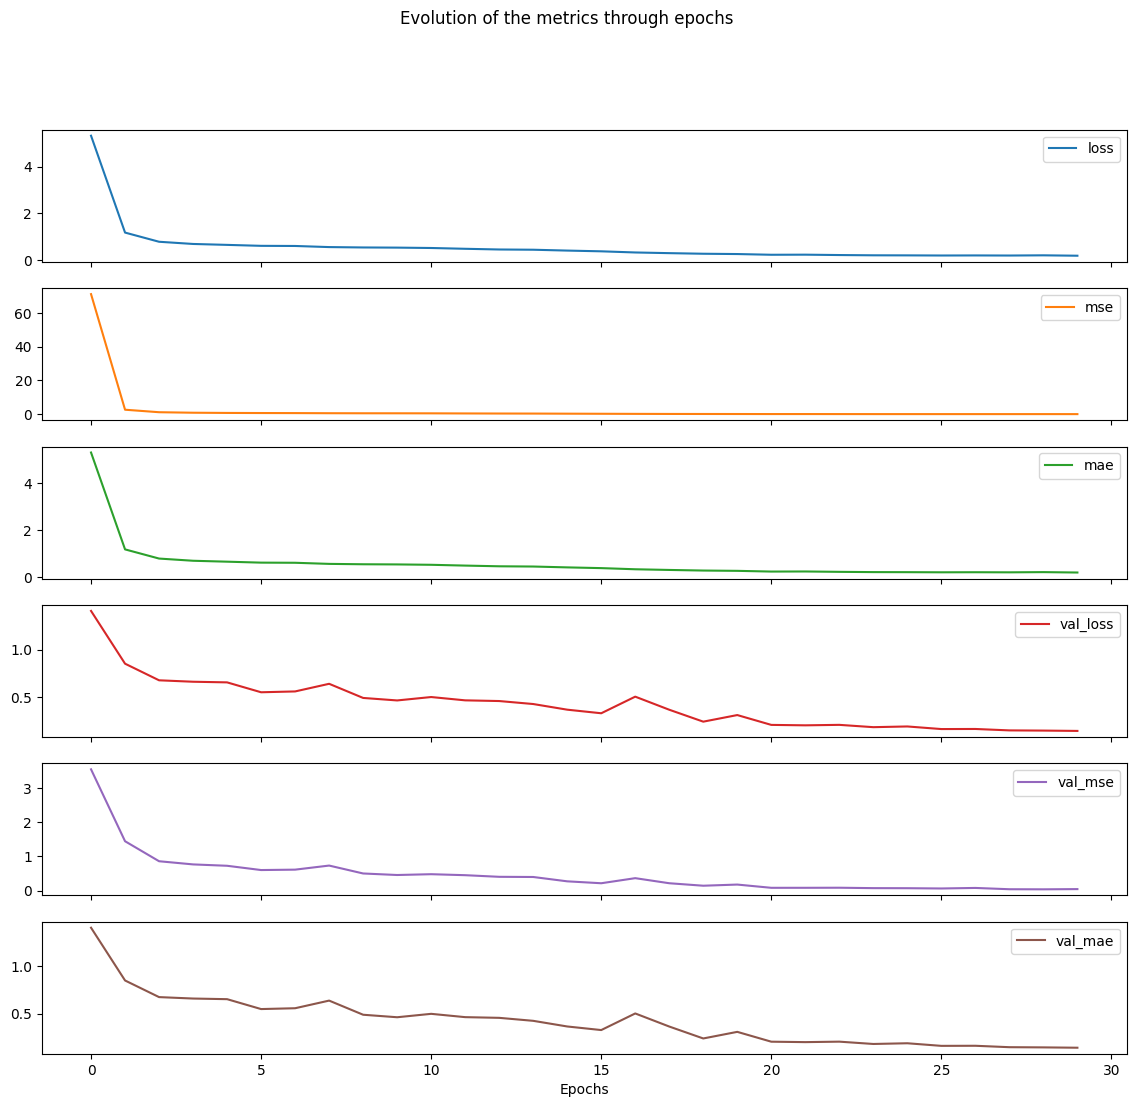

In [930]:
ax = history_df.plot(subplots=True, 
                    figsize=(14,12), 
                    #sharex=True,
                    title="Evolution of the metrics through epochs", 
                    #layout=(4,2)
                    )
_ = [ax[k].set_xlabel("Epochs") for k in range(len(ax))]

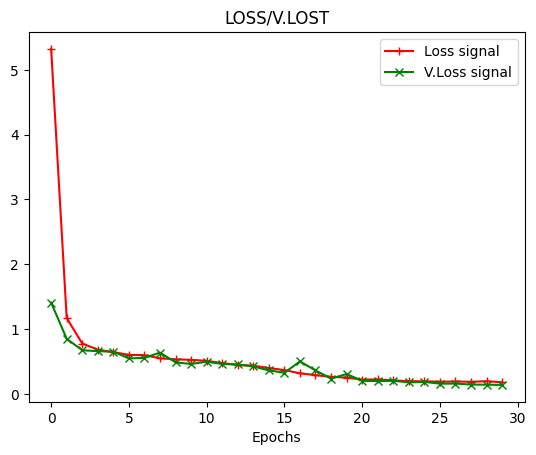

In [915]:
# Plotting the loss and validation loss
plt.plot(history_df['loss'], "r+-", label='Loss signal')
plt.plot(history_df['val_loss'], "gx-", label='V.Loss signal')
plt.title("LOSS/V.LOST")
plt.xlabel("Epochs")
plt.legend()

In [929]:
# Evaluation on the test set with the same parameters (batch_size equal)
scores = model.evaluate(X_test, Y_test,
                       batch_size=10,
                       verbose=0,
                       callbacks=[tqdm_callback])

# Printing in a more human-friendly interface the different scores
s = {k[1]:scores[0] for k in enumerate(METRICS)}
print(f"Statistics ==> {s}")

0/281                   ETA: ?s - Evaluating

Statistics ==> {'loss': 0.1403432935476303, 'mse': 0.1403432935476303, 'mae': 0.1403432935476303}


In [920]:
# Prediction on the test set
Y_pred = model.predict(X_test).flatten()

88/88 [==============================] - 0s 890us/step


In [921]:
# Computing the main statistical indicators
AE = np.abs(Y_pred - Y_test)
SE = np.square(Y_pred - Y_test) 
RSE = np.sqrt(SE)
MAE = np.mean(AE)
MSE = np.mean(SE)
RMSE = np.sqrt(MSE)
print(f"Statistics : \nMAE \t = {MAE}\nMSE \t = {MSE}\nRMSE \t = {RMSE}")

Statistics : 
MAE 	 = 0.1403432820319082
MSE 	 = 0.047079707103610514
RMSE 	 = 0.21697858673982212


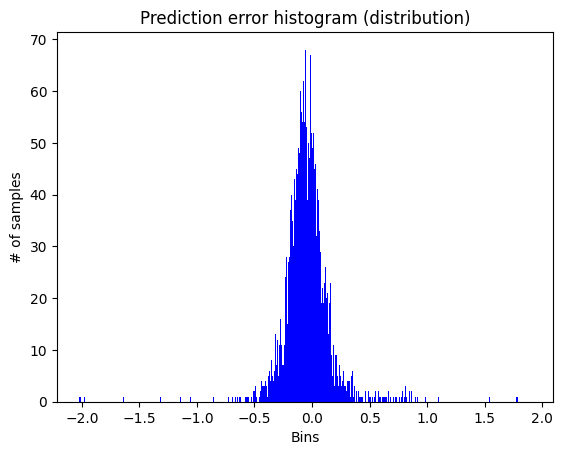

In [976]:
_ = plt.hist(Y_pred - Y_test, bins = 600, color="blue")
_ = plt.title("Prediction error histogram (distribution)")
_, _ = plt.xlabel("Bins"), plt.ylabel("# of samples")

In [923]:
# Within k-sigma ranges where k \in {1, 2, 3}
within_sigma = {k:np.sum(np.abs(Y_pred - Y_test.to_numpy()) < k*RMSE) for k in [0.5, 1, 2, 3, 6]}
print(within_sigma)

{0.5: 1480, 1: 2325, 2: 2702, 3: 2763, 6: 2798}


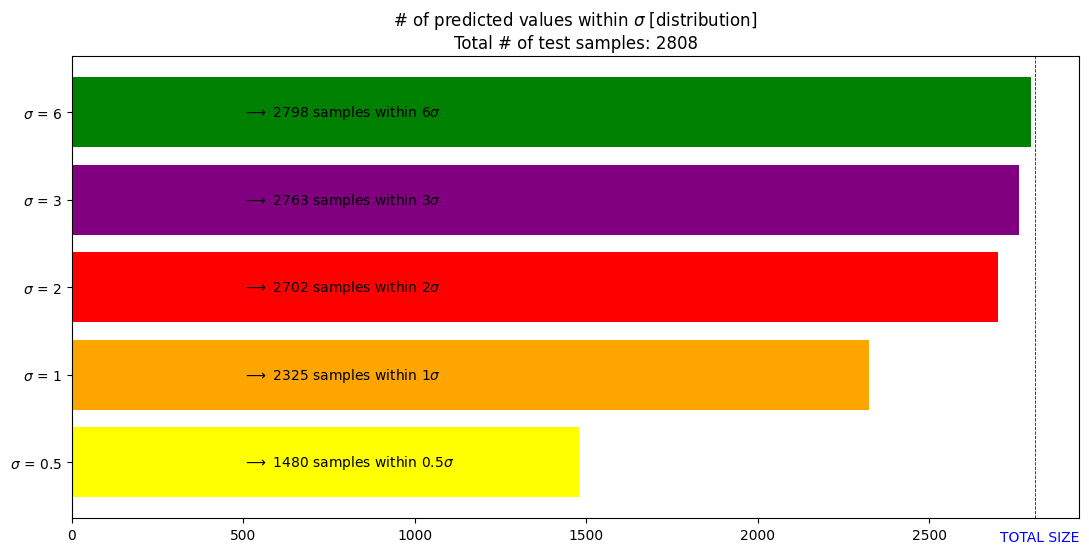

In [924]:
plt.figure(figsize=(13, 6))
_ = plt.barh(range(len(within_sigma)), 
            list(within_sigma.values()), 
            align='center', color=["yellow", "orange", "red", "purple", "green"])
_ = plt.yticks(range(len(within_sigma)), 
               list(["$\sigma$ = " + str(k) for k in within_sigma.keys()]))
for i, v in enumerate(within_sigma.values()):
    _ = plt.text(500, i, f"$\longrightarrow$ {v} samples within {list(within_sigma)[i]}$\sigma$", color='black', va="center")

plt.axvline(x=Y_test.shape[0], color='b', lw=0.6, ls="--")
plt.text(x=Y_test.shape[0] - 100, y = -0.9, s="TOTAL SIZE", color="blue")
_ = plt.title(f"# of predicted values within $\sigma$ [distribution]\nTotal # of test samples: {Y_test.shape[0]}")

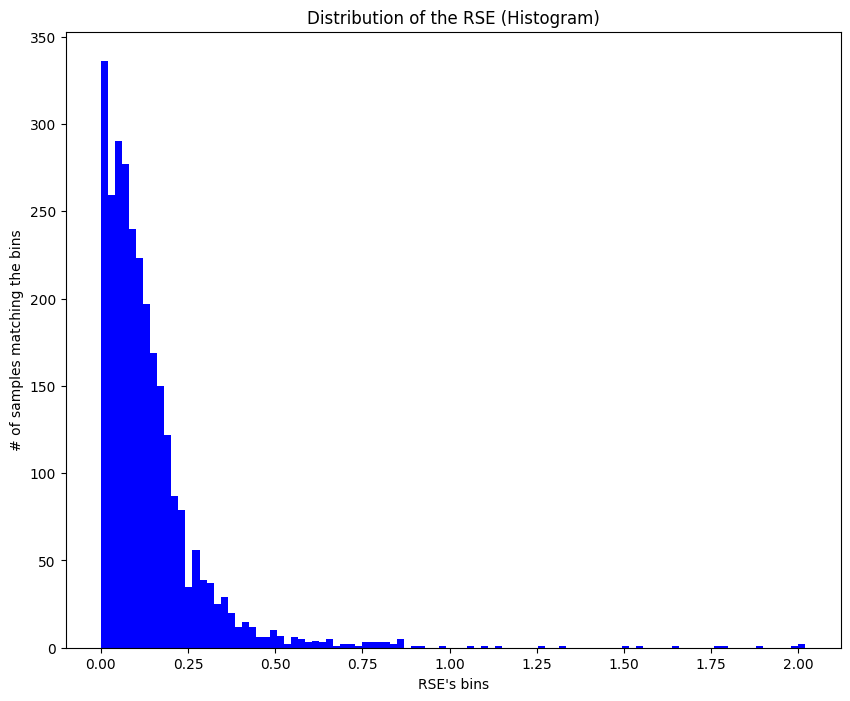

In [925]:
# Histogram of errors
plt.figure(figsize=(10, 8))
plt.title("Distribution of the RSE (Histogram)")
_, _, _ = (plt.hist(RSE, bins=100, color="blue"),
           plt.xlabel("RSE's bins"),
           plt.ylabel("# of samples matching the bins")
          )

Thanks to the previous cell, we can easily recover the number

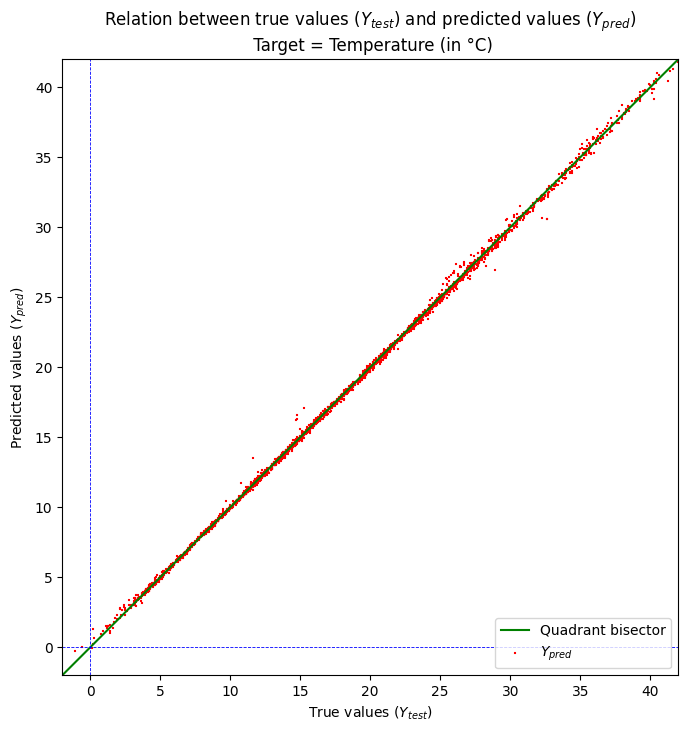

In [941]:
# Plotting the relation between the true values and the predicted ones
plt.figure(figsize=(12, 8))
plt.axes(aspect="equal")
plt.xlabel("True values ($Y_{test}$)")
plt.ylabel("Predicted values ($Y_{pred}$)")
plt.title("Relation between true values ($Y_{test}$) and predicted values ($Y_{pred}$)\n Target = Temperature (in °C)")
_, _ = plt.xlim([-2, 42]), plt.ylim([-2, 42])
plt.plot([-10, 50], [-10, 50], color="green", label="Quadrant bisector")
plt.scatter(Y_test, Y_pred, label="$Y_{pred}$", color="red", s = 1, marker ="+")
plt.axhline(y=0, color='b', lw=0.6, ls="--")
plt.axvline(x=0, color='b', lw=0.6, ls="--")
_ = plt.legend(loc="lower right")
plt.savefig("img/out.svg", dpi=600)

## NN model selection (experiments & simulations)

### Outline & Discussion

Since we have highly detailed the above cells, dedicated to design, fit and predict new values thanks to a Neural Network model, we now want to **precisely determine the best architecture** of our NN 

The following arguments will be tested in order to test a wide range of possible configurations:

We want to study the effect of the following hyper-parameters:
1. Number of layers
2. Number of neurons
3. $\eta$ : Learning rate
4. Presence of regularization techniques ($L_1$, $L_2$, ElasticNet).
5. Activation functions (ReLU, sigmoid function, $\tanh$, linear)



TODO :

- Fixer des valeurs (significatives et extrêmes) par défaut à tester en guide de discrétisation afin de ne pas 
perdre du temps sur un domaine de test trop précis
- Voir les différentes métriques à chaque simulation et 
- Fixer tous les autres paramètres pour voir l'effet d'un seul. Une autre solution consistant à en faire bouger plusieurs en même temps pour optimiser est impossible techniquement (mémoire, temps, ...) et théoriquement


**Remark**: Même si faire bouger un après un est peu significatif, cela nous permet d'avoir une comparaison relative aux autres valeurs d'une même configuration avec un seul paramètre variant



Once we find the most optimal model architecture thanks to the simulation with the above varying parameters, we can conduct a new simulation in order to quantify the effect/impact of :

6. Normalizing the dataset (`X_train` and `X_test`)
7. Noising the normalized dataset

As it can be seen in the above section, designing, compiling, fitting, evaluating and predicting with the model can be a long task to be written and performed.

For shortness and simplicity sakes, we will develop and use in further developments the $4$ following functions:

1. `generate_model(...)` which designs and compiles the model.
2. `fit_model(...)` which fits the model with the training set
3. `plot_score_model(...)` which computes the scores/metrics and plot the main evolutions
4. `predict_model(...)` which predicts and compute several statistical indicators


We now write these highly-commented functions.

### General functions in order to automate the parameters comparison

In [1129]:
def generate_model(eta: float,
                  layers: list, # Input + Hidden layers
                  loss_function: str = "mae",
                  regularization: tuple = (0.0, 0.0)):
    """
    Function generating a new model, defining the network architecture and compiling it
    The returned object corresponds to the compiled model (keras.Sequential)
    """
    
    # Creation of the neural network
    model = Sequential()
    
    print("Defining the NN architecture")
    # Input layer
    nb_neurons = layers[0][0]
    activation_function = layers[0][1]
    model.add(
        Dense(nb_neurons, input_dim=X.shape[1], activation=activation_function)
    )
    
    # Hidden layers
    for layer in layers[1: ]:
        nb_neurons = layer[0]
        activation_function = layer[1]
        model.add(
            Dense(nb_neurons, 
                  activation=activation_function, 
                  kernel_regularizer=tf.keras.regularizers.L1L2(l1=regularization[0], 
                                                                l2=regularization[1])
                 )
        )

    # Output layer
    model.add(Dense(1, activation='linear'))

    # Setting up the optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=eta)

    # Early Stopping
    #es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="max")

    # Compiling the model
    print("Compiling the model")
    model.compile(loss=loss_function, 
                  optimizer=optimizer, 
                  metrics=["mse", "mae"]
                 )
    # Returning the model
    return model

In [1128]:
def fit_model(model, NB_EPOCHS: int = 30, verbose: bool = False):
    """
    Function returning the results of the fitting model
    """
    # Fit step of the model
    print("Fitting the model")
    fit_start = time.time()
    history = model.fit(x=X_train, 
                        y=Y_train, 
                        epochs=NB_EPOCHS,
                        validation_data=(X_test, Y_test),
                        #validation_split=0.3, # mettre validation_data avec X_test, Y_test
                        verbose=verbose,
                        #callbacks=[tqdm_callback], # [es, tqdm_callback],
                        batch_size=10,
                        #workers=8,
                        #use_multiprocessing=True
                       )
    fit_end = time.time()
    fit_dur = np.abs(fit_end - fit_start)
    print(f"Fitting duration: {fit_dur} sec")

    METRICS = model.metrics_names
    print(f"Metrics available: {METRICS}")
    return history

In [999]:
def plot_loss_score_model(model, history, X_test, Y_test, print_metrics=False):
    """
    Function returning the results of the 
    """
    # Gathering the output data from the fitting set
    history_df = pd.DataFrame(history.history)

    # To plot different metrics (if print_metrics is True)
    if print_metrics:
        print("Plotting the metrics evolution")
        ax = history_df.plot(subplots=True, figsize=(14,12), title="Evolution of the metrics through epochs")
        _ = [ax[k].set_xlabel("Epochs") for k in range(len(ax))]

    # Plotting the loss and validation loss
    print("Loss/Validation Loss evolution wrt the epochs")
    plt.figure()
    plt.plot(history_df['loss'], "r+-", label='Loss')
    plt.plot(history_df['val_loss'], "gx-", label='Validation Loss')
    plt.title("Loss and validation loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Evaluation on the test set with the same parameters (batch_size equal)
    print("Evaluation of the model")
    scores = model.evaluate(X_test, Y_test, batch_size=10, verbose=0)

    # Printing in a more human-friendly interface the different scores
    print("Gathering the scores")
    s = {k[1]:scores[0] for k in enumerate(model.metrics_names)}
    return s

In [1006]:
def predict_model(model, X_test, Y_test, plot_graphs: bool = False):
    """
    Function performing the prediction of the model
    """
    
    print("Computing the predictions wrt X_test")
    # Prediction on the test set
    Y_pred = model.predict(X_test).flatten()
        
    print("Computing the main metrics (MAE, MSE & RMSE)")
    # Computing the main prediction error arrays
    AE = np.abs(Y_pred - Y_test)           # Absolute Error
    SE = np.square(Y_pred - Y_test)        # Squared Error
    RSE = np.sqrt(SE)                      # Root Squared Error
    
    # Computing the main statistical indicators
    MAE = np.mean(AE)                      # Mean Absolute Error
    MSE = np.mean(SE)                      # Mean Squared Error
    RMSE = np.sqrt(MSE)                    # Root Mean Squared Error
    
    # Storing the results in a dictionary
    scores = {"MAE": MAE, "MSE": MSE, "RMSE": RMSE}
    
    # Computing the "Within k-sigma" ranges where k \in {1, 2, 3}
    print("Computing the 'Within k-sigma' ranges where k \in {1, 2, 3}")
    within_sigma = {k:np.sum(np.abs(Y_pred - Y_test.to_numpy()) < k*RMSE) for k in [0.5, 1, 2, 3, 6]}  

    # Plotting the graphs
    if plot_graphs:
        print("Plotting the graphs")
        # Plot of the distribution of the Prediction error
        plt.figure()
        _ = plt.hist(Y_pred - Y_test, bins = 600, color="blue")
        _ = plt.title("Prediction error histogram (distribution)")
        _, _ = plt.xlabel("Bins"), plt.ylabel("# of samples")
        
        # Plot the "Within k-sigma" ranges where k \in {1, 2, 3}
        plt.figure(figsize=(13, 6))
        _ = plt.barh(range(len(within_sigma)), 
                    list(within_sigma.values()), 
                    align='center', color=["yellow", "orange", "red", "purple", "green"])
        _ = plt.yticks(range(len(within_sigma)), 
                       list(["$\sigma$ = " + str(k) for k in within_sigma.keys()]))
        for i, v in enumerate(within_sigma.values()):
            _ = plt.text(500, i, f"$\longrightarrow$ {v} samples within {list(within_sigma)[i]}$\sigma$", color='black', va="center")

        plt.axvline(x=Y_test.shape[0], color='b', lw=0.6, ls="--")
        plt.text(x=Y_test.shape[0] - 100, y = -0.9, s="TOTAL SIZE", color="blue")
        _ = plt.title(f"# of predicted values within $\sigma$ [distribution]\nTotal # of test samples: {Y_test.shape[0]}")
        
        # Histogram of errors
        plt.figure(figsize=(10, 8))
        plt.title("Distribution of the RSE (Histogram)")
        _, _, _ = (plt.hist(RSE, bins=100, color="blue"),
                   plt.xlabel("RSE's bins"),
                   plt.ylabel("# of samples matching the bins")
                  )
        
        # Plotting the relation between the true values and the predicted ones
        plt.figure(figsize=(12, 8))
        plt.axes(aspect="equal")
        plt.xlabel("True values ($Y_{test}$)")
        plt.ylabel("Predicted values ($Y_{pred}$)")
        plt.title("Relation between true values ($Y_{test}$) and predicted values ($Y_{pred}$)\n Target = Temperature (in °C)")
        _, _ = plt.xlim([-2, 42]), plt.ylim([-2, 42])
        plt.plot([-10, 50], [-10, 50], color="green", label="Quadrant bisector")
        plt.scatter(Y_test, Y_pred, label="$Y_{pred}$", color="red", s = 1, marker ="+")
        plt.axhline(y=0, color='b', lw=0.6, ls="--")
        plt.axvline(x=0, color='b', lw=0.6, ls="--")
        _ = plt.legend(loc="lower right")
        plt.savefig("img/out.svg", dpi=600)
        
    return {"scores": scores, "sigma-intervals": within_sigma}

In [1098]:
def show_architecture_model(model):
    """
    Function creating, showing and saving on disk the NN model architecture
    """
    dt = datetime.datetime.now().strftime("%d/%m/%Y_%H:%M:%S")
    filename = f"out_{dt}"
    print(filename)
    plot_model(model,
               to_file=f"img/{filename}_A.png",
               rankdir="LR")
    visualizer(model, 
               filename=f"img/{filename}_B", 
               format="png", 
               view=False
              )
    Image(f"img/{filename}_A.png")

We can test the chain of these functions by executing the following cell:

Defining the NN architecture
Compiling the model
Fitting the model


Training:   0%|     0/30 ETA: ?s,  ?epochs/s

Epoch 1/30


0/655                             ETA: ?s - 

Epoch 2/30


0/655                             ETA: ?s - 

Epoch 3/30


0/655                             ETA: ?s - 

Epoch 4/30


0/655                             ETA: ?s - 

Epoch 5/30


0/655                             ETA: ?s - 

Epoch 6/30


0/655                             ETA: ?s - 

Epoch 7/30


0/655                             ETA: ?s - 

Epoch 8/30


0/655                             ETA: ?s - 

Epoch 9/30


0/655                             ETA: ?s - 

Epoch 10/30


0/655                             ETA: ?s - 

Epoch 11/30


0/655                             ETA: ?s - 

Epoch 12/30


0/655                             ETA: ?s - 

Epoch 13/30


0/655                             ETA: ?s - 

Epoch 14/30


0/655                             ETA: ?s - 

Epoch 15/30


0/655                             ETA: ?s - 

Epoch 16/30


0/655                             ETA: ?s - 

Epoch 17/30


0/655                             ETA: ?s - 

Epoch 18/30


0/655                             ETA: ?s - 

Epoch 19/30


0/655                             ETA: ?s - 

Epoch 20/30


0/655                             ETA: ?s - 

Epoch 21/30


0/655                             ETA: ?s - 

Epoch 22/30


0/655                             ETA: ?s - 

Epoch 23/30


0/655                             ETA: ?s - 

Epoch 24/30


0/655                             ETA: ?s - 

Epoch 25/30


0/655                             ETA: ?s - 

Epoch 26/30


0/655                             ETA: ?s - 

Epoch 27/30


0/655                             ETA: ?s - 

Epoch 28/30


0/655                             ETA: ?s - 

Epoch 29/30


0/655                             ETA: ?s - 

Epoch 30/30


0/655                             ETA: ?s - 

Fitting duration: 24.609446048736572 sec
Metrics available: ['loss', 'mse', 'mae']
Loss/Validation Loss evolution wrt the epochs
Evaluation of the model
Gathering the scores
Computing the predictions wrt X_test
88/88 [==============================] - 0s 573us/step
Computing the main metrics (MAE, MSE & RMSE)
Computing the 'Within k-sigma' ranges where k \in {1, 2, 3}


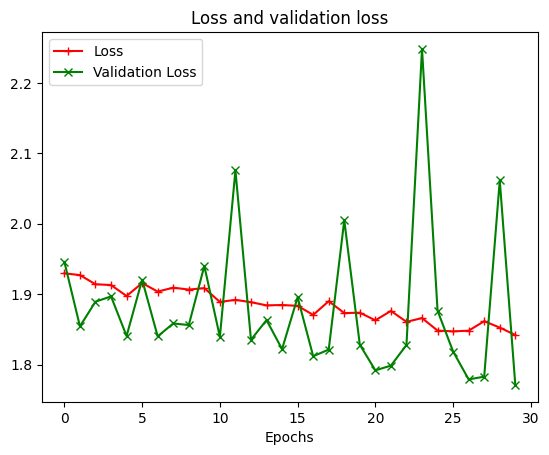

In [1100]:
model = generate_model(eta=2e-3, 
                   layers=[
                       (12, "relu"),
                       (10, "relu"),
                       (10, "relu"),
                       (10, "relu"),
                   ], loss_function="mse", regularization=(1, 1))

history = fit_model(m)
plot_loss_score_model(m, history, X_test, Y_test, print_metrics=False)

prediction_results = predict_model(m, X_test, Y_test, False)
scores, sigmas = prediction_results["scores"], prediction_results["sigma-intervals"]

In [1122]:
scores, sigmas

({'MAE': 0.23942595725206778,
  'MSE': 0.12345237224425547,
  'RMSE': 0.351357897654593},
 {0.5: 1401, 1: 2198, 2: 2702, 3: 2771, 6: 2803})

### Impact of the number of layers

We have decided to only test the following number of layers:


$$
2, \ 3, \ 4, \ 5
$$

These numbers corresponds to the input layer + the number of hidden layers

=============== Simulation for 2 layers
Defining the NN architecture
Compiling the model
Fitting the model
Fitting duration: 9.279431819915771 sec
Metrics available: ['loss', 'mse', 'mae']
Loss/Validation Loss evolution wrt the epochs
Evaluation of the model
Gathering the scores
Computing the predictions wrt X_test
88/88 [==============================] - 0s 610us/step
Computing the main metrics (MAE, MSE & RMSE)
Computing the 'Within k-sigma' ranges where k \in {1, 2, 3}
{'MAE': 1.7335758515310074, 'MSE': 5.410323753364426, 'RMSE': 2.326010265102978} {0.5: 1290, 1: 2044, 2: 2680, 3: 2773, 6: 2808}
=============== Simulation for 3 layers
Defining the NN architecture
Compiling the model
Fitting the model
Fitting duration: 9.496463775634766 sec
Metrics available: ['loss', 'mse', 'mae']
Loss/Validation Loss evolution wrt the epochs
Evaluation of the model
Gathering the scores
Computing the predictions wrt X_test
88/88 [==============================] - 0s 617us/step
Computing the main met

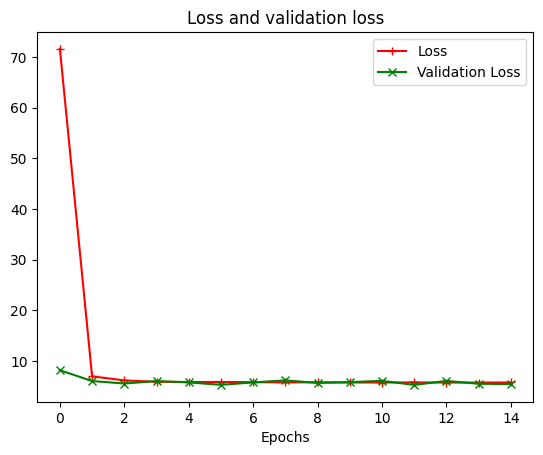

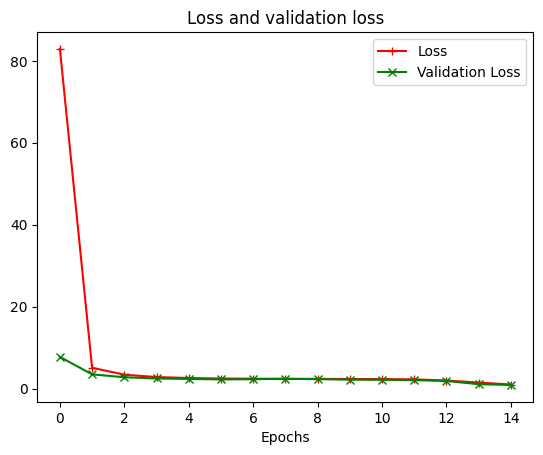

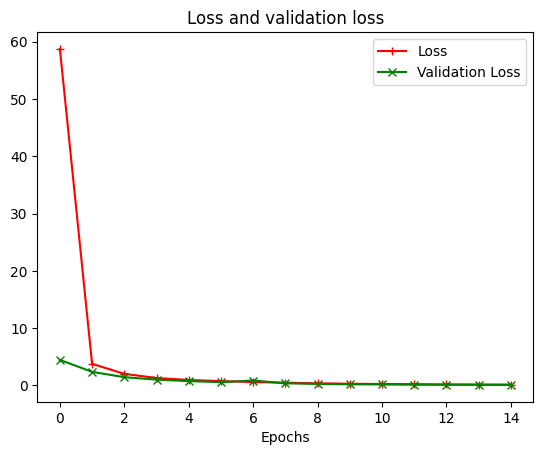

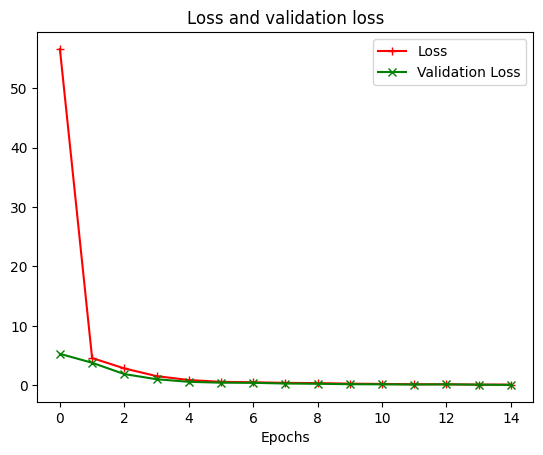

In [1163]:
PARAMS = [2, 3, 4, 5]
stats = {k: {"scores": [], "sigmas": []} for k in PARAMS}
for k in PARAMS:
    print(f"=============== Simulation for {k} layers")
    model = generate_model(eta=2e-3, layers=[(10, "relu") for _ in range(k)], loss_function="mse")
    history = fit_model(model, NB_EPOCHS=15)
    plot_loss_score_model(model, history, X_test, Y_test, print_metrics=False)
    prediction_results = predict_model(model, X_test, Y_test, False)
    scores, sigmas = prediction_results["scores"], prediction_results["sigma-intervals"]
    print(scores, sigmas)
    stats[k]["scores"] = scores
    stats[k]["sigmas"] = sigmas

In [1165]:
pd.DataFrame(stats)

,2,3,4,5
scores,"{'MAE': 1.7335758515310074, 'MSE': 5.410323753...","{'MAE': 0.6844006092496935, 'MSE': 0.887742257...","{'MAE': 0.22965658531260466, 'MSE': 0.09821240...","{'MAE': 0.20328158937525334, 'MSE': 0.07748493..."
sigmas,"{0.5: 1290, 1: 2044, 2: 2680, 3: 2773, 6: 2808}","{0.5: 1353, 1: 2103, 2: 2653, 3: 2775, 6: 2807}","{0.5: 1255, 1: 2132, 2: 2673, 3: 2766, 6: 2807}","{0.5: 1290, 1: 2082, 2: 2678, 3: 2790, 6: 2803}"


In [1166]:
stats

{2: {'scores': {'MAE': 1.7335758515310074,
   'MSE': 5.410323753364426,
   'RMSE': 2.326010265102978},
  'sigmas': {0.5: 1290, 1: 2044, 2: 2680, 3: 2773, 6: 2808}},
 3: {'scores': {'MAE': 0.6844006092496935,
   'MSE': 0.8877422577602834,
   'RMSE': 0.9422007523666511},
  'sigmas': {0.5: 1353, 1: 2103, 2: 2653, 3: 2775, 6: 2807}},
 4: {'scores': {'MAE': 0.22965658531260466,
   'MSE': 0.09821240988946796,
   'RMSE': 0.31338859246862827},
  'sigmas': {0.5: 1255, 1: 2132, 2: 2673, 3: 2766, 6: 2807}},
 5: {'scores': {'MAE': 0.20328158937525334,
   'MSE': 0.07748493651767316,
   'RMSE': 0.2783611620138003},
  'sigmas': {0.5: 1290, 1: 2082, 2: 2678, 3: 2790, 6: 2803}}}

We have conducted the experiment with four different values for the number of layers.

We observe that we have a minimized RMSE for a 5-layers (1 input + 4 hidden layers) NN architecture.

Moreover, thanks to the graphs, we can see that the convergence behavior is faster with this number of layers

$\longrightarrow$ For further simulations, we decide to keep unchange the number of layers.

### Impact of the number of neurons/layers

We have decided to test the following the number of neurons per layer


$$
6, \ 8, \ 10, \ 12
$$


**Remark**: We have chosen these values because we want to restrain our study to a number of neurons which are close the input dimension (here : 10).


**Remark**: We make the following assumptions:
1. Each layer has a uniform number (same number) of neurons.
2. Each layer has a ReLU activation function with no regularization method.

=============== Simulation for 6 neurons/layer (5 layers)
Defining the NN architecture
Compiling the model
Fitting the model
Fitting duration: 10.282027006149292 sec
Metrics available: ['loss', 'mse', 'mae']
Loss/Validation Loss evolution wrt the epochs
Evaluation of the model
Gathering the scores
Computing the predictions wrt X_test
88/88 [==============================] - 0s 642us/step
Computing the main metrics (MAE, MSE & RMSE)
Computing the 'Within k-sigma' ranges where k \in {1, 2, 3}
{'MAE': 0.3322966044958056, 'MSE': 0.22154709920599583, 'RMSE': 0.47068789999956} {0.5: 1300, 1: 2168, 2: 2695, 3: 2778, 6: 2803}
=============== Simulation for 8 neurons/layer (5 layers)
Defining the NN architecture
Compiling the model
Fitting the model
Fitting duration: 10.347425937652588 sec
Metrics available: ['loss', 'mse', 'mae']
Loss/Validation Loss evolution wrt the epochs
Evaluation of the model
Gathering the scores
Computing the predictions wrt X_test
88/88 [==============================]

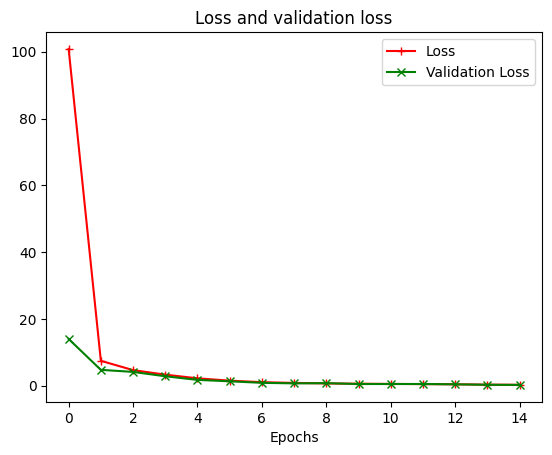

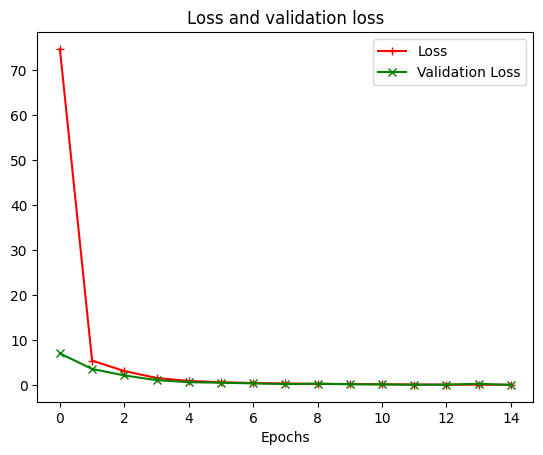

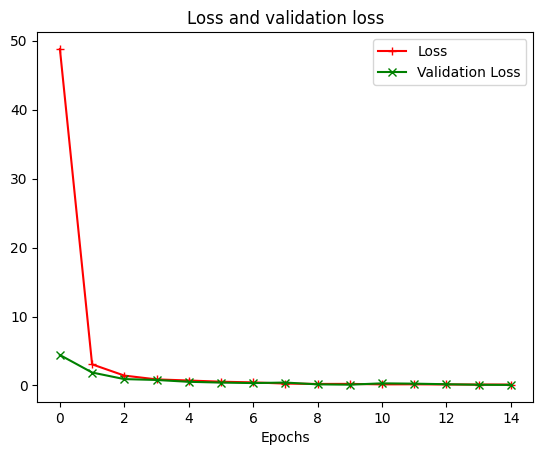

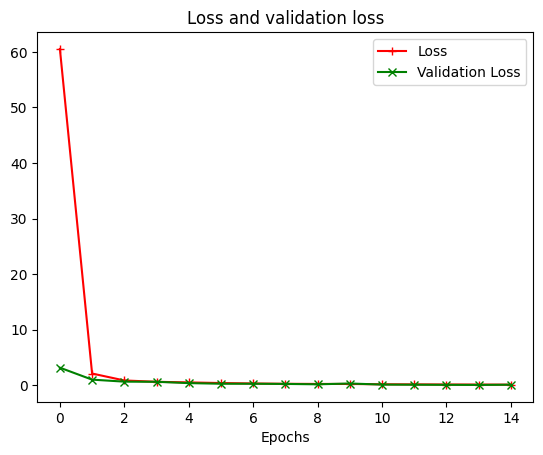

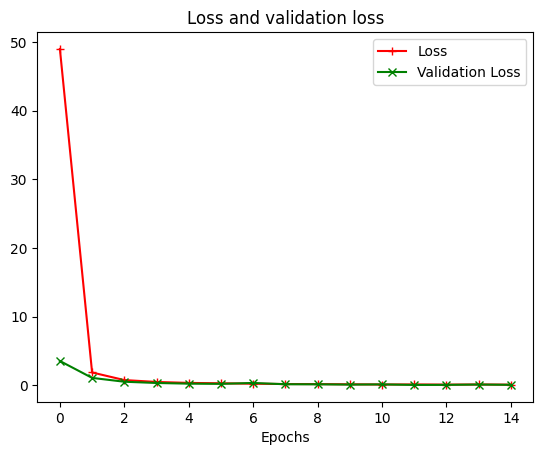

In [1172]:
PARAMS = [6, 8, 10, 12, 14]
stats = {k: {"scores": [], "sigmas": []} for k in PARAMS}
for k in PARAMS:
    print(f"=============== Simulation for {k} neurons/layer (5 layers)")
    model = generate_model(eta=2e-3, layers=[(k, "relu") for _ in range(5)], loss_function="mse")
    history = fit_model(model, NB_EPOCHS=15)
    plot_loss_score_model(model, history, X_test, Y_test, print_metrics=False)
    prediction_results = predict_model(model, X_test, Y_test, False)
    scores, sigmas = prediction_results["scores"], prediction_results["sigma-intervals"]
    print(scores, sigmas)
    stats[k]["scores"] = scores
    stats[k]["sigmas"] = sigmas

In [1175]:
stats

{6: {'scores': {'MAE': 0.3322966044958056,
   'MSE': 0.22154709920599583,
   'RMSE': 0.47068789999956},
  'sigmas': {0.5: 1300, 1: 2168, 2: 2695, 3: 2778, 6: 2803}},
 8: {'scores': {'MAE': 0.25904530576299145,
   'MSE': 0.11724694292138682,
   'RMSE': 0.3424134093773006},
  'sigmas': {0.5: 1217, 1: 2051, 2: 2657, 3: 2785, 6: 2807}},
 10: {'scores': {'MAE': 0.20614651097002884,
   'MSE': 0.08196045759828297,
   'RMSE': 0.2862873689115239},
  'sigmas': {0.5: 1332, 1: 2127, 2: 2664, 3: 2773, 6: 2805}},
 12: {'scores': {'MAE': 0.26595486254041806,
   'MSE': 0.11359762539573663,
   'RMSE': 0.3370424682376638},
  'sigmas': {0.5: 1025, 1: 1966, 2: 2683, 3: 2794, 6: 2807}},
 14: {'scores': {'MAE': 0.20860212808467932,
   'MSE': 0.07885901189119437,
   'RMSE': 0.2808184678599226},
  'sigmas': {0.5: 1261, 1: 2096, 2: 2655, 3: 2769, 6: 2807}}}

We observe that the MSE reaches its lowest value for $10$ or $14$ neurons per layer. The study of the within-$\sigma$ intervals and the convergence behavior (thanks to the plots) are really great for these values too.

$\longrightarrow$ For complexity minimization sake, we can will choose the lower one which is $10$ neurons per layer.

### Impact of $\eta$ : learning rate

=============== Simulation for eta = 0.01 (5 layers & 10 neurons/layer)
Defining the NN architecture
Compiling the model
Fitting the model
Fitting duration: 10.23308801651001 sec
Metrics available: ['loss', 'mse', 'mae']
Loss/Validation Loss evolution wrt the epochs
Evaluation of the model
Gathering the scores
Computing the predictions wrt X_test
88/88 [==============================] - 0s 636us/step
Computing the main metrics (MAE, MSE & RMSE)
Computing the 'Within k-sigma' ranges where k \in {1, 2, 3}
{'MAE': 0.22421896209749537, 'MSE': 0.0880655542705565, 'RMSE': 0.2967584106146892} {0.5: 1178, 1: 2041, 2: 2707, 3: 2789, 6: 2804}
=============== Simulation for eta = 0.04 (5 layers & 10 neurons/layer)
Defining the NN architecture
Compiling the model
Fitting the model
Fitting duration: 10.351020097732544 sec
Metrics available: ['loss', 'mse', 'mae']
Loss/Validation Loss evolution wrt the epochs
Evaluation of the model
Gathering the scores
Computing the predictions wrt X_test
88/88 [==

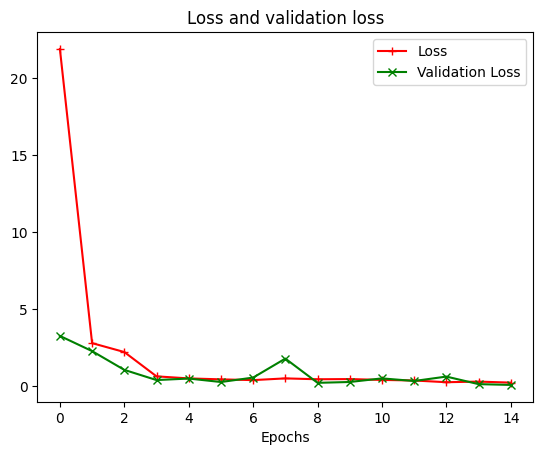

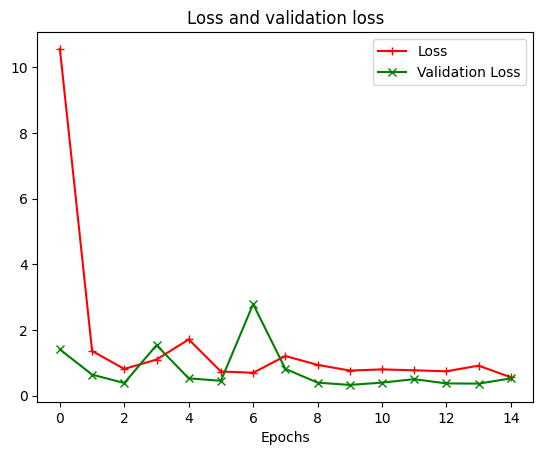

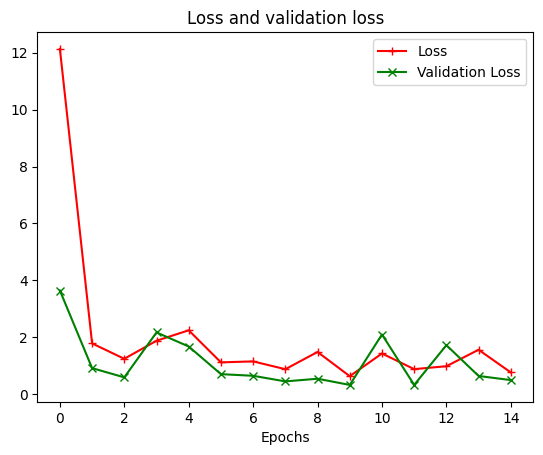

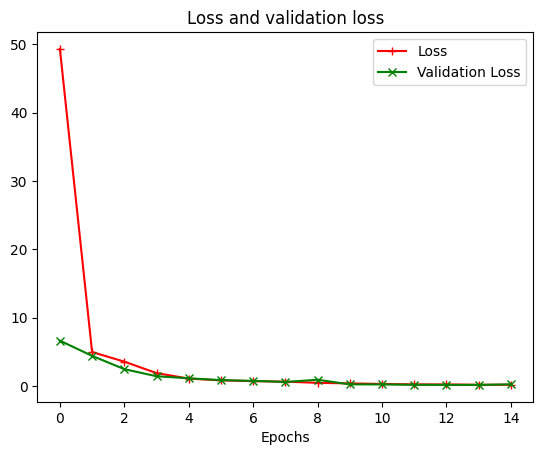

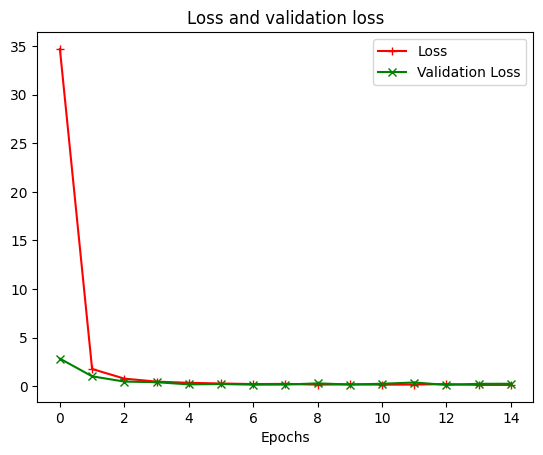

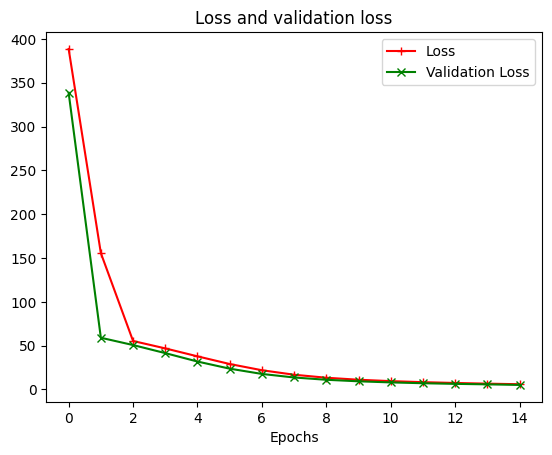

In [1180]:
PARAMS = [1e-2, 4e-2, 7e-2, 2e-3, 5e-3, 1e-4]
stats = {k: {"scores": [], "sigmas": []} for k in PARAMS}
for k in PARAMS:
    print(f"=============== Simulation for eta = {k} (5 layers & 10 neurons/layer)")
    model = generate_model(eta=k, layers=[(10, "relu") for _ in range(5)], loss_function="mse")
    history = fit_model(model, NB_EPOCHS=15)
    plot_loss_score_model(model, history, X_test, Y_test, print_metrics=False)
    prediction_results = predict_model(model, X_test, Y_test, False)
    scores, sigmas = prediction_results["scores"], prediction_results["sigma-intervals"]
    print(scores, sigmas)
    stats[k]["scores"] = scores
    stats[k]["sigmas"] = sigmas

In [1182]:
stats

{0.01: {'scores': {'MAE': 0.22421896209749537,
   'MSE': 0.0880655542705565,
   'RMSE': 0.2967584106146892},
  'sigmas': {0.5: 1178, 1: 2041, 2: 2707, 3: 2789, 6: 2804}},
 0.04: {'scores': {'MAE': 0.5660011620463404,
   'MSE': 0.5267180691810609,
   'RMSE': 0.7257534493070363},
  'sigmas': {0.5: 1168, 1: 1928, 2: 2684, 3: 2795, 6: 2808}},
 0.07: {'scores': {'MAE': 0.5595616694177817,
   'MSE': 0.49844213824715944,
   'RMSE': 0.706004347187154},
  'sigmas': {0.5: 972, 1: 2040, 2: 2695, 3: 2787, 6: 2807}},
 0.002: {'scores': {'MAE': 0.3964511209222145,
   'MSE': 0.23060645756010278,
   'RMSE': 0.48021501180211223},
  'sigmas': {0.5: 840, 1: 1904, 2: 2736, 3: 2789, 6: 2807}},
 0.005: {'scores': {'MAE': 0.4467467381988846,
   'MSE': 0.2712673075362611,
   'RMSE': 0.5208332819014748},
  'sigmas': {0.5: 733, 1: 1823, 2: 2724, 3: 2804, 6: 2808}},
 0.0001: {'scores': {'MAE': 1.7572656572088798,
   'MSE': 5.14855518242366,
   'RMSE': 2.269042789905836},
  'sigmas': {0.5: 1123, 1: 2000, 2: 2673,

We can clearly observe that the RMSE and MSE are minimized by the value $\eta^* = 2\times 10^{-3}$ in both cases.

In addition, the convergence for this value of $\eta$ seems to be the fastest and most stable one compared to the others plots.

Finally, the interval $\left[-3\sigma, 3\sigma\right]$ contains more than $99\%$ of the values.

$\longrightarrow$ We then decide to choose $\eta^* = 2\times 10^{-3}$ for the future computations.

### Impact of regularization ($L_1$, $L_2$, ElasticNet)

=============== Simulation for (L1,L2) = (1, 0) (5 layers, 10 neurons/layer & eta = 2e-3)
Defining the NN architecture
Compiling the model
Fitting the model
Fitting duration: 10.983123064041138 sec
Metrics available: ['loss', 'mse', 'mae']
Loss/Validation Loss evolution wrt the epochs
Evaluation of the model
Gathering the scores
Computing the predictions wrt X_test
88/88 [==============================] - 0s 635us/step
Computing the main metrics (MAE, MSE & RMSE)
Computing the 'Within k-sigma' ranges where k \in {1, 2, 3}
{'MAE': 0.7044891765774076, 'MSE': 0.8805250433307467, 'RMSE': 0.9383629592704236} {0.5: 1190, 1: 2052, 2: 2703, 3: 2772, 6: 2807}
=============== Simulation for (L1,L2) = (0.25, 0.75) (5 layers, 10 neurons/layer & eta = 2e-3)
Defining the NN architecture
Compiling the model
Fitting the model
Fitting duration: 10.741410970687866 sec
Metrics available: ['loss', 'mse', 'mae']
Loss/Validation Loss evolution wrt the epochs
Evaluation of the model
Gathering the scores
Comp

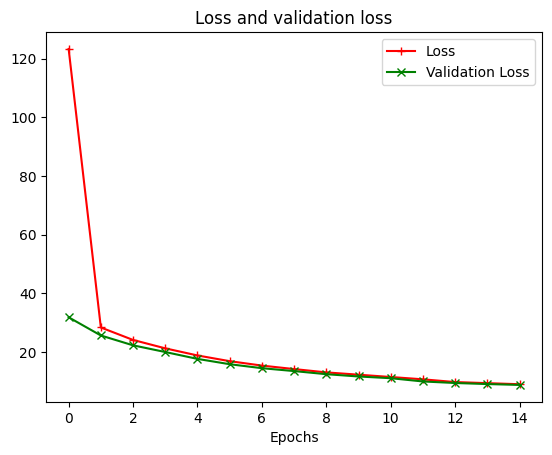

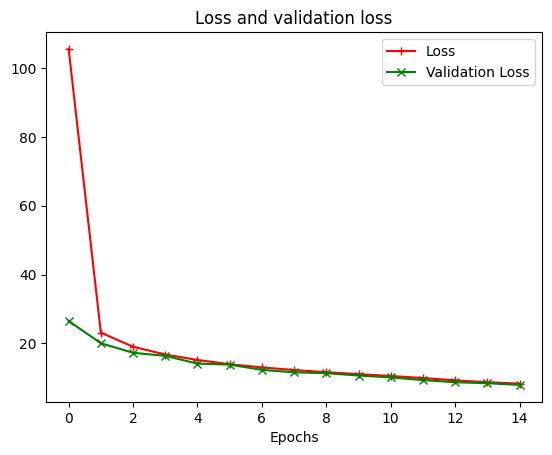

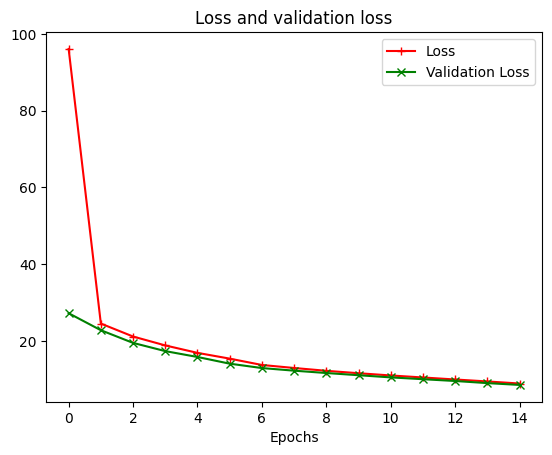

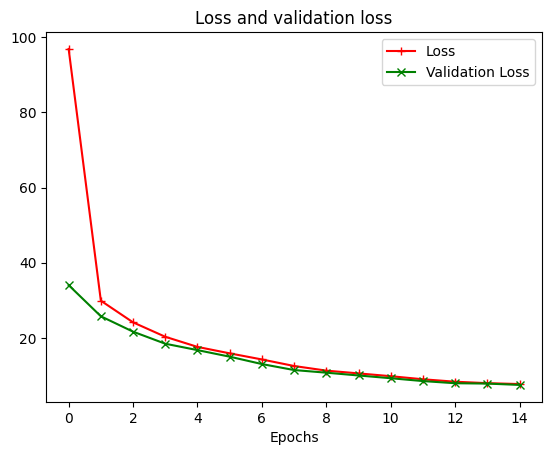

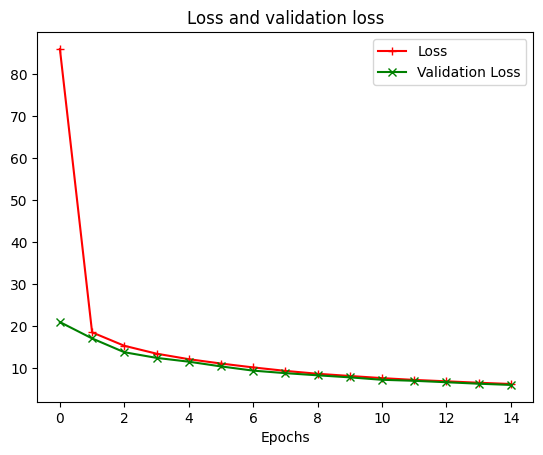

In [1193]:
PARAMS = [(1, 0), (1/4, 3/4), (1/2, 1/2), (3/4, 1/4), (0, 1)]
stats = {k: {"scores": [], "sigmas": []} for k in PARAMS}
for k in PARAMS:
    print(f"=============== Simulation for (L1,L2) = {k} (5 layers, 10 neurons/layer & eta = 2e-3)")
    model = generate_model(eta=2e-3, layers=[(10, "relu") for _ in range(5)], loss_function="mse", regularization=k)
    history = fit_model(model, NB_EPOCHS=15)
    plot_loss_score_model(model, history, X_test, Y_test, print_metrics=False)
    prediction_results = predict_model(model, X_test, Y_test, False)
    scores, sigmas = prediction_results["scores"], prediction_results["sigma-intervals"]
    print(scores, sigmas)
    stats[k]["scores"] = scores
    stats[k]["sigmas"] = sigmas

In [1195]:
stats

{(1,
  0): {'scores': {'MAE': 0.7044891765774076,
   'MSE': 0.8805250433307467,
   'RMSE': 0.9383629592704236}, 'sigmas': {0.5: 1190,
   1: 2052,
   2: 2703,
   3: 2772,
   6: 2807}},
 (0.25,
  0.75): {'scores': {'MAE': 0.78778766035656,
   'MSE': 1.1689473057937603,
   'RMSE': 1.0811786650659363}, 'sigmas': {0.5: 1226,
   1: 2138,
   2: 2691,
   3: 2763,
   6: 2807}},
 (0.5,
  0.5): {'scores': {'MAE': 0.7287139700232991,
   'MSE': 1.0555700503287357,
   'RMSE': 1.0274093878920592}, 'sigmas': {0.5: 1313,
   1: 2180,
   2: 2691,
   3: 2761,
   6: 2803}},
 (0.75,
  0.25): {'scores': {'MAE': 0.6667426802108195,
   'MSE': 0.8230196905360954,
   'RMSE': 0.9072043267842671}, 'sigmas': {0.5: 1234,
   1: 2125,
   2: 2694,
   3: 2766,
   6: 2807}},
 (0,
  1): {'scores': {'MAE': 0.6667452589076522,
   'MSE': 0.8507178190408176,
   'RMSE': 0.9223436556082649}, 'sigmas': {0.5: 1273,
   1: 2142,
   2: 2693,
   3: 2767,
   6: 2804}}}

We can remark that in the case of fully $L_1$ or $L_2$ regularization, the MSE and RMSE are really low compared to the intermediary ElasticNet method.

In addition, we can see that the ElasticNet convergence speed is slower than the ones from $L_1$ and $L_2$ (red curve from loss evolution on the graphs).


$\longrightarrow$ We simply choose to keep a $L_1$ regularization

### Impact of activation functions

We consider the following activation functions : **ReLU**, **Sigmoid**, $\tanh$ and **linear**.

**Remark**: We make the assumption that each layer will have the same activation function.

=============== Simulation for AF = relu (5 layers, 10 neurons/layer, eta = 2e-3 & L1 regularization)
Defining the NN architecture
Compiling the model
Fitting the model
Fitting duration: 11.295767068862915 sec
Metrics available: ['loss', 'mse', 'mae']
Loss/Validation Loss evolution wrt the epochs
Evaluation of the model
Gathering the scores
Computing the predictions wrt X_test
88/88 [==============================] - 0s 715us/step
Computing the main metrics (MAE, MSE & RMSE)
Computing the 'Within k-sigma' ranges where k \in {1, 2, 3}
Plotting the graphs
{'MAE': 0.7182599666340854, 'MSE': 0.9983858392205832, 'RMSE': 0.9991925936577909} {0.5: 1286, 1: 2146, 2: 2708, 3: 2771, 6: 2802}
=============== Simulation for AF = sigmoid (5 layers, 10 neurons/layer, eta = 2e-3 & L1 regularization)
Defining the NN architecture
Compiling the model
Fitting the model
Fitting duration: 11.985203981399536 sec
Metrics available: ['loss', 'mse', 'mae']
Loss/Validation Loss evolution wrt the epochs
Evaluati

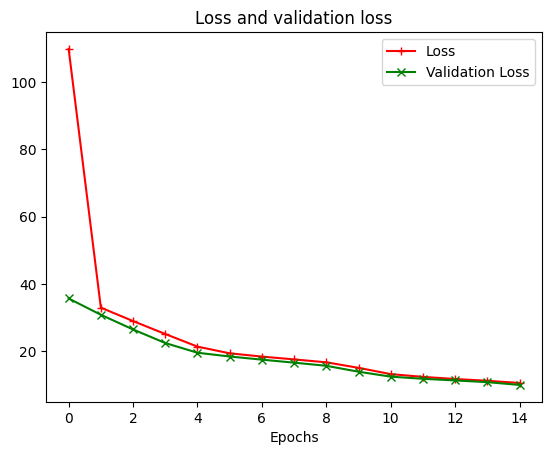

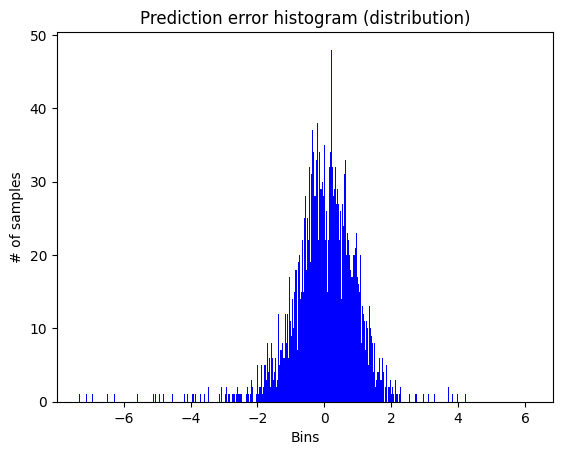

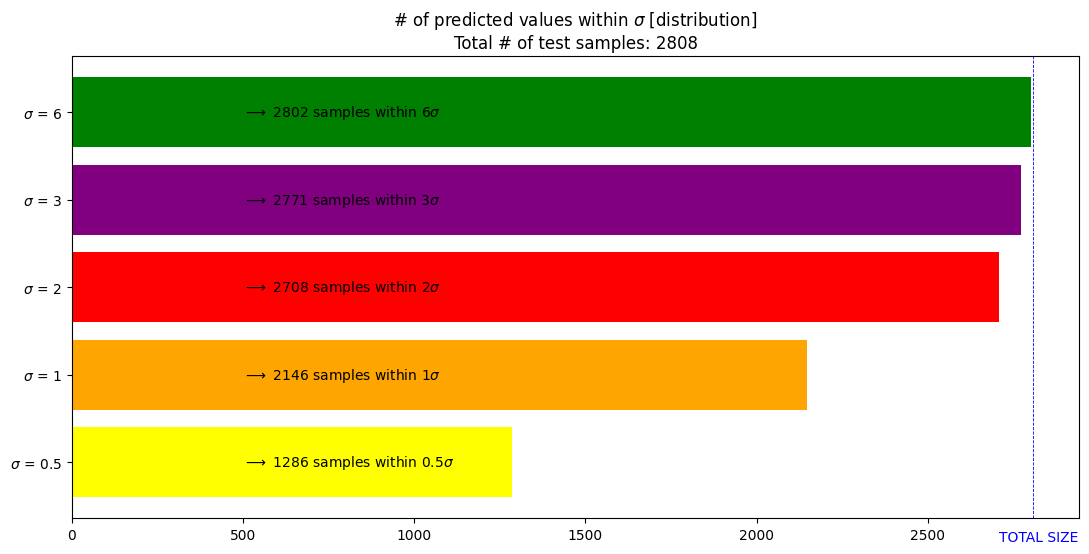

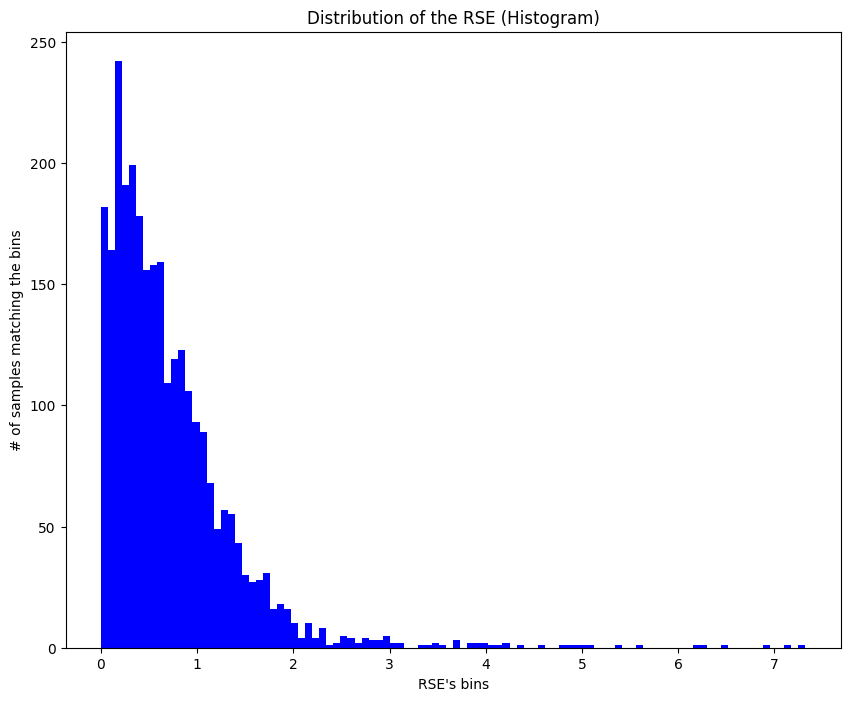

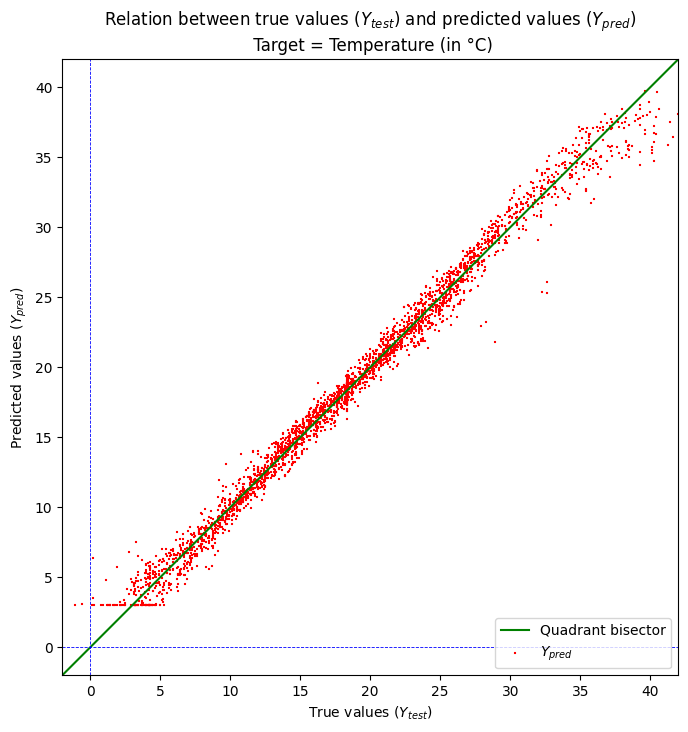

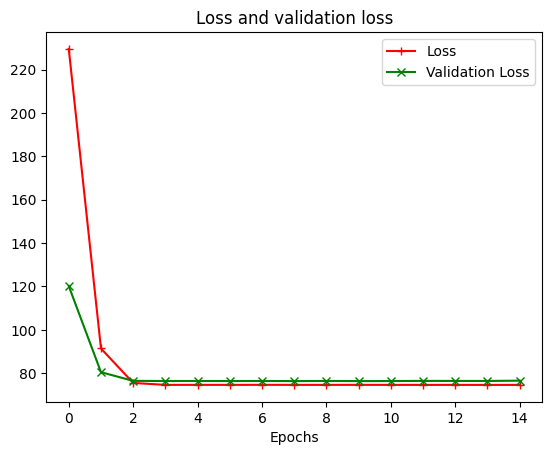

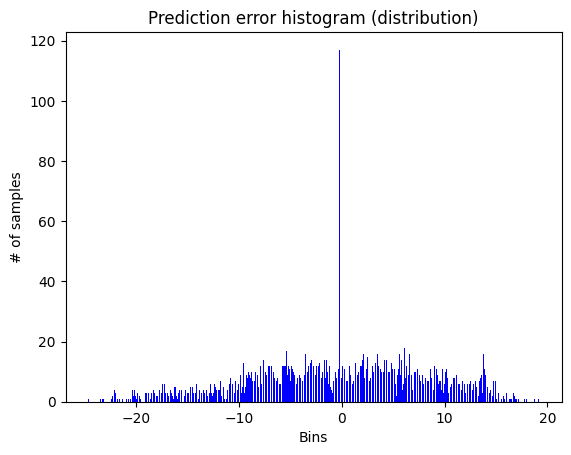

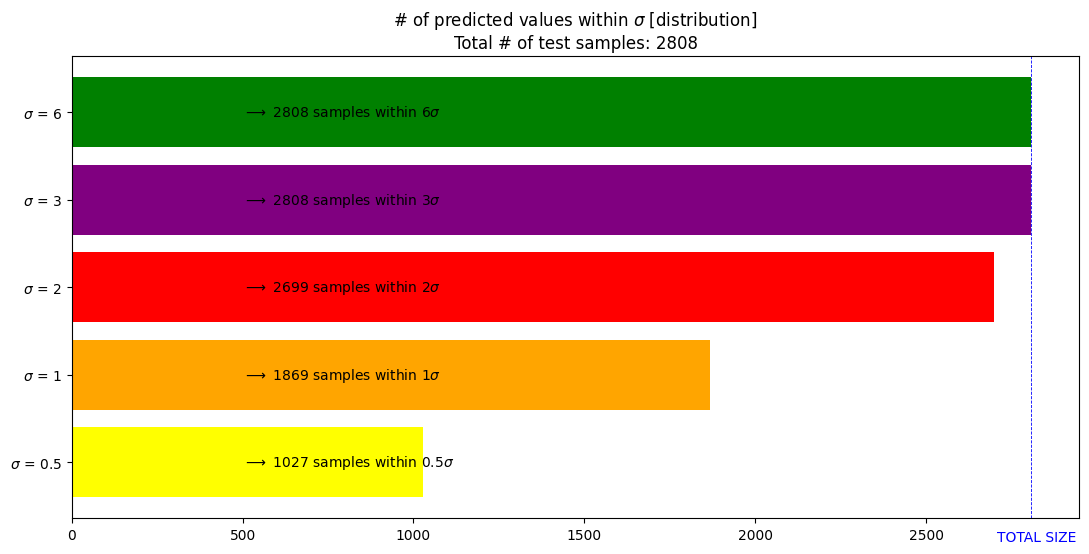

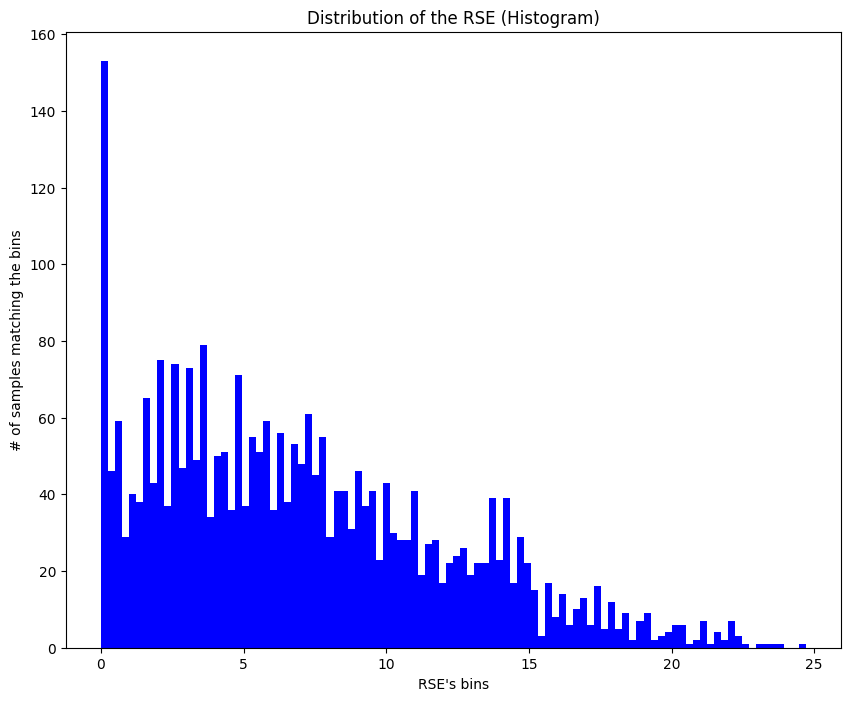

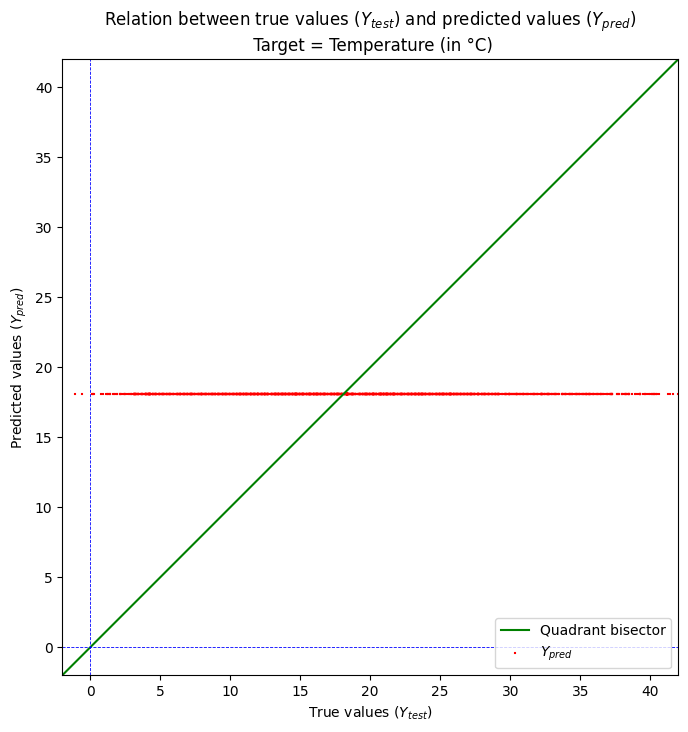

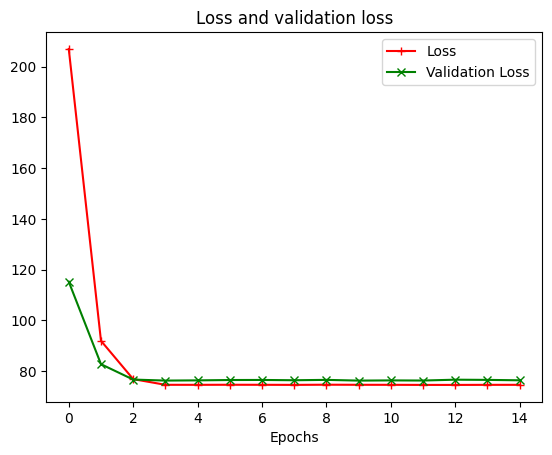

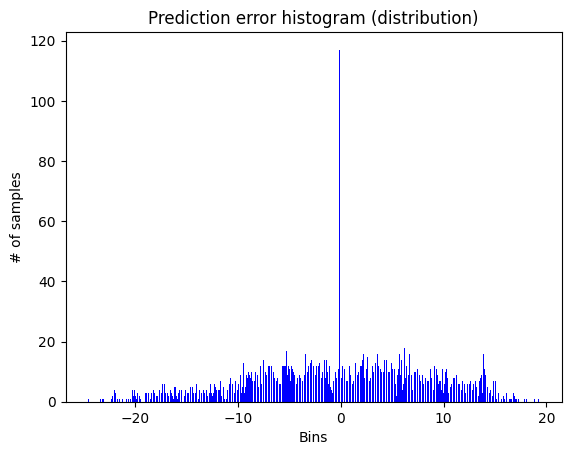

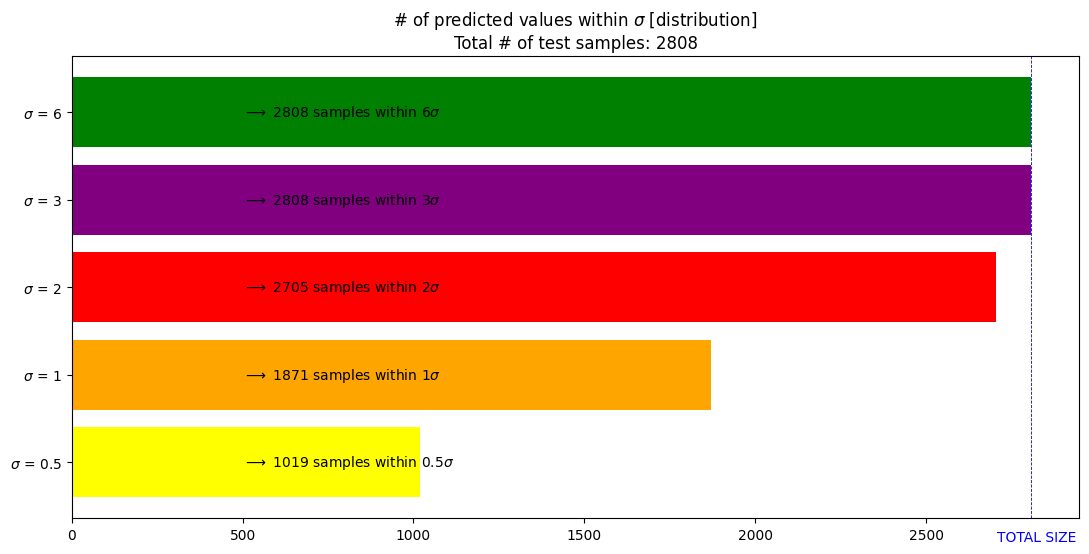

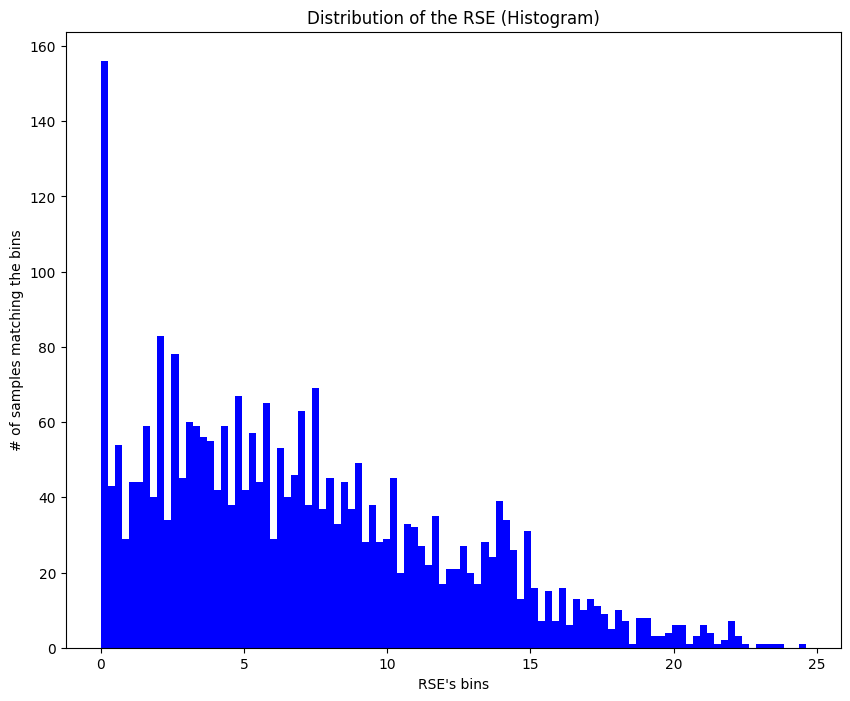

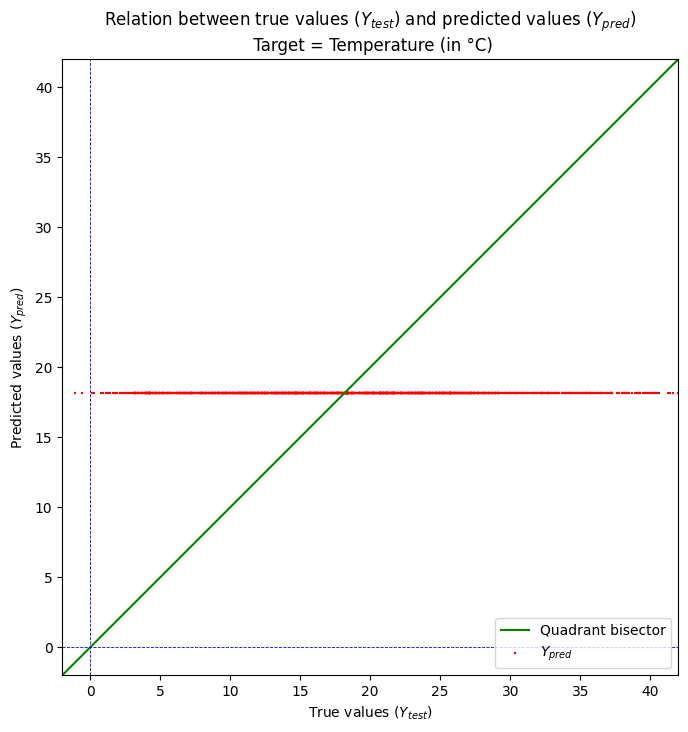

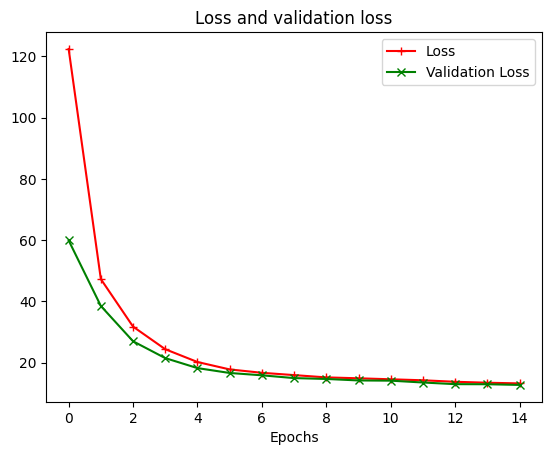

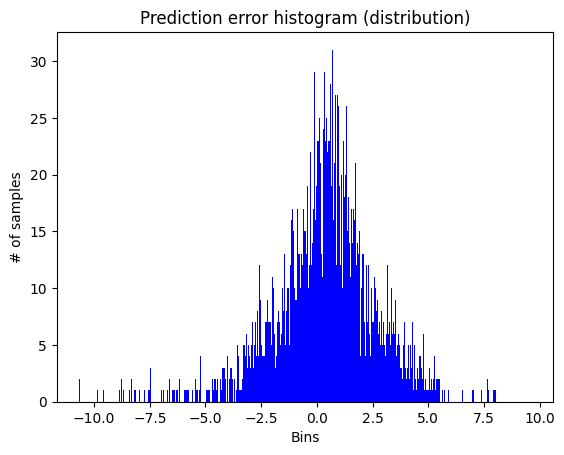

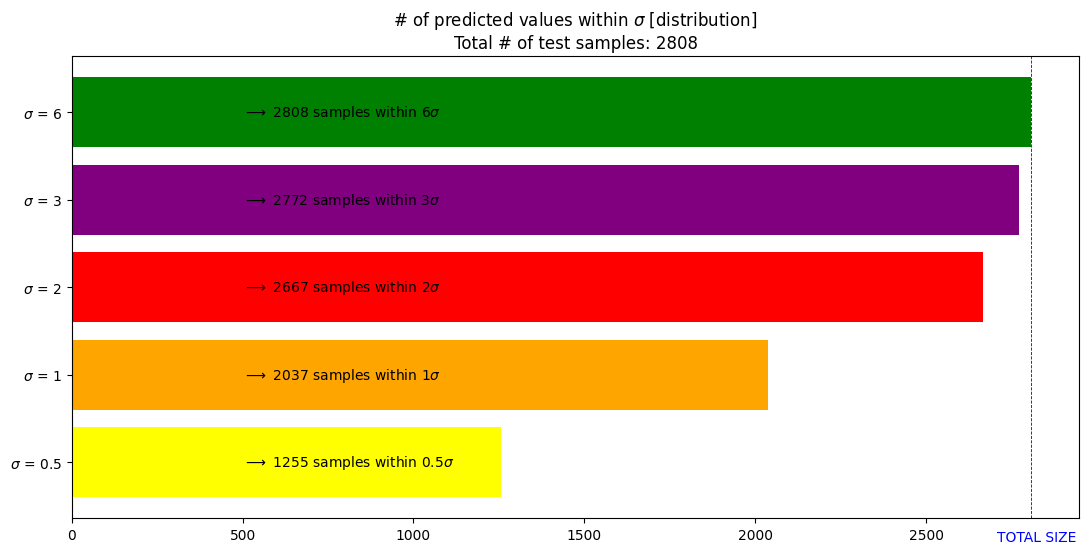

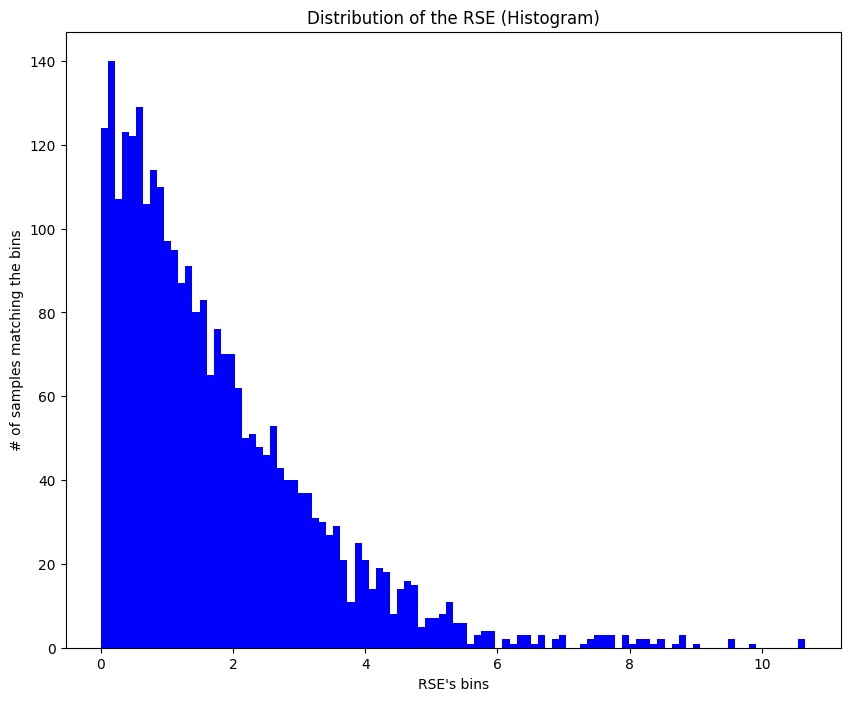

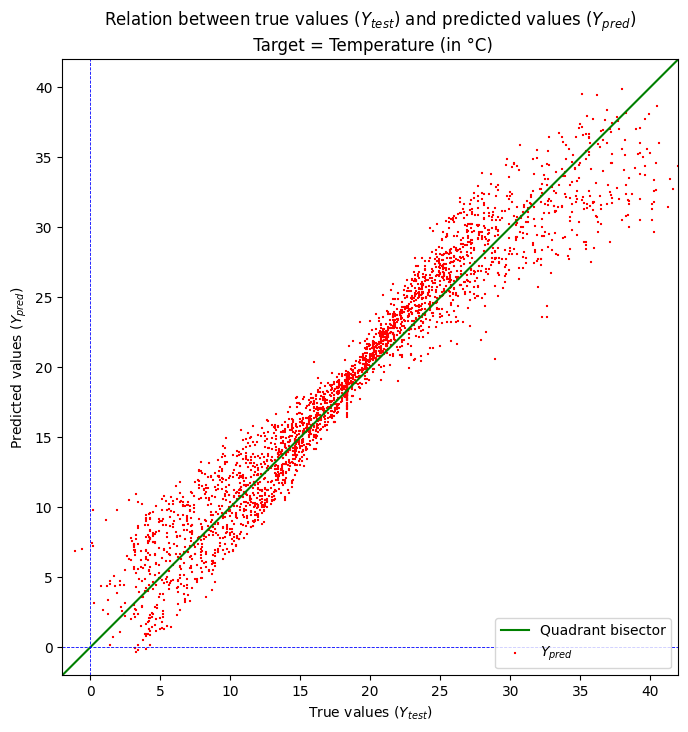

In [1200]:
PARAMS = ["relu", "sigmoid", "tanh", "linear"]
stats = {k: {"scores": [], "sigmas": []} for k in PARAMS}
for k in PARAMS:
    print(f"=============== Simulation for AF = {k} (5 layers, 10 neurons/layer, eta = 2e-3 & L1 regularization)")
    model = generate_model(eta=2e-3, layers=[(10, k) for _ in range(5)], loss_function="mse", regularization=(1, 0))
    history = fit_model(model, NB_EPOCHS=15)
    plot_loss_score_model(model, history, X_test, Y_test, print_metrics=False)
    prediction_results = predict_model(model, X_test, Y_test, True)
    scores, sigmas = prediction_results["scores"], prediction_results["sigma-intervals"]
    print(scores, sigmas)
    stats[k]["scores"] = scores
    stats[k]["sigmas"] = sigmas

In [1198]:
stats

{'relu': {'scores': {'MAE': 0.8897328119683651,
   'MSE': 1.406372887038743,
   'RMSE': 1.1859059351562176},
  'sigmas': {0.5: 1183, 1: 2095, 2: 2682, 3: 2771, 6: 2808}},
 'sigmoid': {'scores': {'MAE': 7.073346072026653,
   'MSE': 76.20850539317385,
   'RMSE': 8.72974830067705},
  'sigmas': {0.5: 1012, 1: 1868, 2: 2707, 3: 2808, 6: 2808}},
 'tanh': {'scores': {'MAE': 7.092725340575082,
   'MSE': 76.22520586863656,
   'RMSE': 8.730704775024554},
  'sigmas': {0.5: 1012, 1: 1871, 2: 2713, 3: 2808, 6: 2808}},
 'linear': {'scores': {'MAE': 1.729180885327558,
   'MSE': 5.255895145025376,
   'RMSE': 2.2925739126635323},
  'sigmas': {0.5: 1231, 1: 2010, 2: 2678, 3: 2776, 6: 2808}}}

**ReLU** minimizes the MSE and RMSE.

$\longrightarrow$ **ReLU** is the "best" activation function which is kept in order to design the final optimal model.


**Remark**: The second best one is **linear**. This can be explained by the fact that we are in the situation of a linear regression.

### Impact of normalization

### Noise impact after normalization

We want to study the impact of noising the train dataset **after normalization**.

In order to do so, we declare a function tailored to **noise** the features.


**Noising strategy**: For the $i$-th feature within the training set


$$X_i \longleftarrow \alpha X_i + \beta\mathcal{N}(0, \sigma_i) + \gamma $$

where $\sigma_i$ represents the variance of the feature $i$, $\alpha$, $\beta$ and $\gamma$ two real numbers.


**Remark**: We have chosen to noise **ONLY** the training set. We keep the test set unchanged for the same reason we left it unchanged while we were deciding to handle or not outliers.

In [1112]:
def noising_features(X):
    """
    Function generating and applying a noised version on all the features of a given dataset
    """
    # Defining the global variables
    alpha = 1.04
    beta = 4
    gamma = - 0.007
    
    # Deepcopying the features (for security reason)
    d = copy.deepcopy(X)
    
    # Iterating on each feature
    for c in range(X.shape[1]):
        # Computing the variance of the feature
        std_col = np.var(d[:, c])
        
        # Computing the additive part of the noise
        d[:, c] = np.random.normal(0, beta*std_col, size=(X.shape[0],))
    
    # Applying and returning the final noise
    return alpha*X + d + gamma

We can apply that function on our `X_train` :

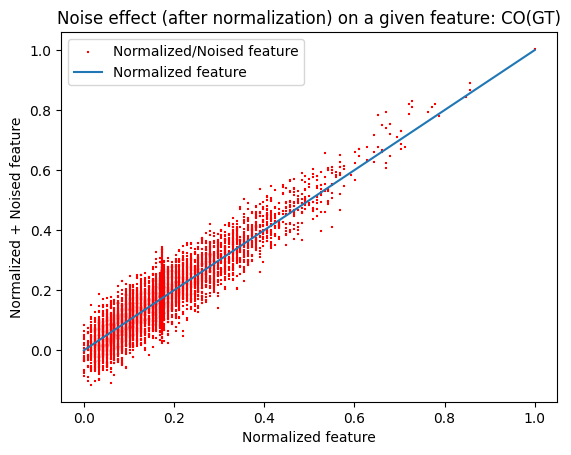

In [1113]:
# Computing the noisy features
X_train_noise = noising_features(X_train)

# Plotting the results
_ = plt.scatter(X_train.T[0],X_train_noise.T[0],s=2, marker='+' ,c="r", label="Normalized/Noised feature")
x = np.linspace(0, 1, 100)
_ = plt.plot(x,x, label="Normalized feature")
plt.xlabel("Normalized feature")
plt.ylabel("Normalized + Noised feature")
_ = plt.title("Noise effect (after normalization) on a given feature: CO(GT)")
_ = plt.legend()

We can also estimate the difference element-wise speaking:

In [1121]:
pd.DataFrame(X_train_noise - X_train)

,0,1,2,3,4,5,6,7,8,9
0,0.066032,0.076753,0.080124,-0.011107,0.004100,-0.081977,0.079373,0.201248,-0.597263,-0.526957
1,-0.036317,0.185881,-0.008246,-0.008277,0.047688,-0.007670,-0.136657,0.175040,-0.316361,-0.047135
2,0.037419,-0.117312,-0.189073,-0.017415,-0.099925,0.005910,-0.158239,-0.366007,-0.740099,-0.025327
3,0.022583,-0.060250,-0.129039,0.080342,-0.053819,0.043857,-0.049065,-0.040167,-0.249532,0.079964
4,-0.027932,0.043171,0.070827,-0.043407,0.049034,-0.124114,0.055218,-0.086532,-0.289840,0.097121
...,...,...,...,...,...,...,...,...,...,...
6544,-0.059343,0.033609,-0.079923,-0.078495,-0.019804,-0.072340,-0.204961,0.060172,-0.459885,0.020123
6545,-0.004973,-0.186058,0.054754,0.081522,0.131570,-0.159154,0.076445,-0.161022,-0.029614,-0.692071
6546,0.060226,0.124511,-0.118011,-0.036500,0.001864,0.060380,0.238184,0.111614,-0.116778,-0.195787
6547,-0.034127,-0.006047,0.020537,0.034267,0.121426,0.000865,0.092420,0.057830,-0.295868,0.167287


## Conclusion

---

**Lucas RODRIGUEZ** (Sep. - Oct. 2022)